# Periodic Boundary Conditions

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS

## Direct Hamiltonian

In [2]:
def direct_ham(l, L, g, U: int=0, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*(L+1) + l*L
    
    # initialize
    O = csc_array((2**dof, 2**dof), dtype=complex)
    I = identity(2**dof, dtype=complex)
    H_sigmas = O
    H_taus = O
    H_plaquettes = O
    H_gauss = O
    
    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1

    # horizontal terms
    for i in range(l*L):
        H_taus += sparse_pauli_x(n=i, L=dof)

    # vertical terms
    for i in range(l*L,l*(L+1)+l*L):
        H_sigmas += sparse_pauli_x(n=i, L=dof)

    # plaquettes terms
    for j in range(l):
        for i in range(L):
            H_plaquettes += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+L+j*(L))%(l*L), L=dof) @ sparse_pauli_z(n=(i+l*L+j*(L+1)), L=dof) @ sparse_pauli_z(n=(i+l*L+1+j*(L+1)), L=dof)

    # gauss law on the left
    i = 0
    for j in range(1,l+1):
        G_j = (sparse_pauli_x(n=i+l*L+(j-1)*(L+1), L=dof) @ sparse_pauli_x(n=(i+L+(j-1)*(L))%(l*L), L=dof) @ sparse_pauli_x(n=i+l*L+((j)*(L+1))%(l*(L+1)), L=dof))
        H_gauss += (G_j - I * charges[j%l,i]) @ (G_j - I * charges[j%l,i])

    # gauss law on the right
    i = L
    for j in range(1,l+1):
        G_j = (sparse_pauli_x(n=(i+l*L+(j-1)*(L+1)), L=dof) @ sparse_pauli_x(n=(i-1+L+(j-1)*(L))%(l*L), L=dof) @ sparse_pauli_x(n=i+l*L+((j)*(L+1))%(l*(L+1)), L=dof))
        H_gauss += (G_j - I * charges[j%l,i]) @ (G_j - I * charges[j%l,i])

    # gauss law on the bulk
    for i in range(1,L):
        for j in range(1,l+1):
            G_j = (sparse_pauli_x(n=i+l*L+(j-1)*(L+1), L=dof) @ sparse_pauli_x(n=(i-1+L+(j-1)*(L))%(l*L), L=dof) @ sparse_pauli_x(n=i+l*L+((j)*(L+1))%(l*(L+1)), L=dof) @ sparse_pauli_x(n=(i+L+(j-1)*(L))%(l*L), L=dof))
            H_gauss += (G_j - I * charges[j%l,i]) @ (G_j - I * charges[j%l,i])

    return - g * H_sigmas - g * H_taus - 1/g * H_plaquettes + U * H_gauss

In [3]:
l, L = 2,2
dof_gauss = l*(L+1)
for j in range(l):
    for i in range(L):
        print(i+j*L, (i+L+j*(L))%(l*L), (i+l*L+j*(L+1)), (i+l*L+1+j*(L+1)))

0 2 4 5
1 3 5 6
2 0 7 8
3 1 8 9


In [4]:
l, L = 2,2
i = 0
for j in range(1,l+1):
    print((i+l*L+(j-1)*(L+1)), (i+L+(j-1)*(L))%(l*L), (i+l*L+((j)*(L+1))%(l*(L+1))))

4 2 7
7 0 4


In [5]:
l, L = 2,2
i = L
for j in range(1,l+1):
    print((i+l*L+(j-1)*(L+1)), (i-1+L+(j-1)*(L))%(l*L), (i+l*L+((j)*(L+1))%(l*(L+1))))

6 3 9
9 1 6


In [6]:
l, L = 3,3
for i in range(1,L):
    for j in range(1,l+1):
        print((i+l*L+(j-1)*(L+1)), (i-1+L+(j-1)*(L))%(l*L), (i+l*L+((j)*(L+1))%(l*(L+1))), (i+L+(j-1)*(L))%(l*L))

10 3 14 4
14 6 18 7
18 0 10 1
11 4 15 5
15 7 19 8
19 1 11 2


In [7]:
l = 2
L = 2
g = 1
dof_gauss = l*L + 1
H_dir = direct_ham(l,L,g, U=100)
e, v = diagonalization(H_dir, sparse=False)
print(e[(2**dof_gauss)-2:(2**dof_gauss)+2], len(e))


[  6.87365913   6.90551107 791.25210492 791.25210492] 1024


## Dual Hamiltonian

In [8]:
def dual_ham(l,L,g, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*L + 1

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()
    
    # initialize
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O
    H_plaquettes = O

    # first column of sigma are local
    for i in range(l):
        H_sigmas += sparse_pauli_z(n=i*L, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

    # vertical zz interactions 
    for j in range(L):
        for i in range(l):
            H_taus += np.prod(charges[(i+1)%l,:(j+1)]) * sparse_pauli_z(n=i*L+j, L=dof) @ sparse_pauli_z(n=((i+1)%l)*L+j, L=dof)

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)

    return - g * H_sigmas - g * H_taus - 1/g * H_plaquettes

def dual_ham_topo(l,L,g, cx: list=[], cy: list=[], topol: int=1):
    # degrees of freedom
    dof = l*L

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()
    
    # initialize
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O
    H_plaquettes = O

    # first column of sigma are local
    for i in range(l):
        H_sigmas += sparse_pauli_z(n=i*L, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        H_sigmas += topol * np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof)

    # vertical zz interactions 
    for j in range(L):
        for i in range(l):
            H_taus += np.prod(charges[(i+1)%l,:(j+1)]) * sparse_pauli_z(n=i*L+j, L=dof) @ sparse_pauli_z(n=((i+1)%l)*L+j, L=dof)

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)

    return - g * H_sigmas - g * H_taus - 1/g * H_plaquettes

In [9]:
L = 2
l = 2
g = 1
dof = l*L + 1
H_dual = dual_ham(l,L,g)
e,v = diagonalization(H_dual, sparse=False)
print(e[(2**dof)-2:], len(e))

[6.87365913 6.90551107] 32


## Compare Direct and Dual

Computing g: 0.5
Computing g: 0.52
Computing g: 0.54
Computing g: 0.56
Computing g: 0.58
Computing g: 0.6
Computing g: 0.62
Computing g: 0.64
Computing g: 0.66
Computing g: 0.6799999999999999
Computing g: 0.7
Computing g: 0.72
Computing g: 0.74
Computing g: 0.76
Computing g: 0.78
Computing g: 0.8
Computing g: 0.8200000000000001
Computing g: 0.8400000000000001
Computing g: 0.86
Computing g: 0.88
Computing g: 0.9
Computing g: 0.9199999999999999
Computing g: 0.94
Computing g: 0.96
Computing g: 0.98
Computing g: 1.0
Computing g: 1.02
Computing g: 1.04
Computing g: 1.06
Computing g: 1.08
Computing g: 1.1
Computing g: 1.12
Computing g: 1.1400000000000001
Computing g: 1.1600000000000001
Computing g: 1.1800000000000002
Computing g: 1.2000000000000002
Computing g: 1.22
Computing g: 1.24
Computing g: 1.26
Computing g: 1.28
Computing g: 1.3
Computing g: 1.32
Computing g: 1.3399999999999999
Computing g: 1.3599999999999999
Computing g: 1.38
Computing g: 1.4
Computing g: 1.42
Computing g: 1.44
Compu

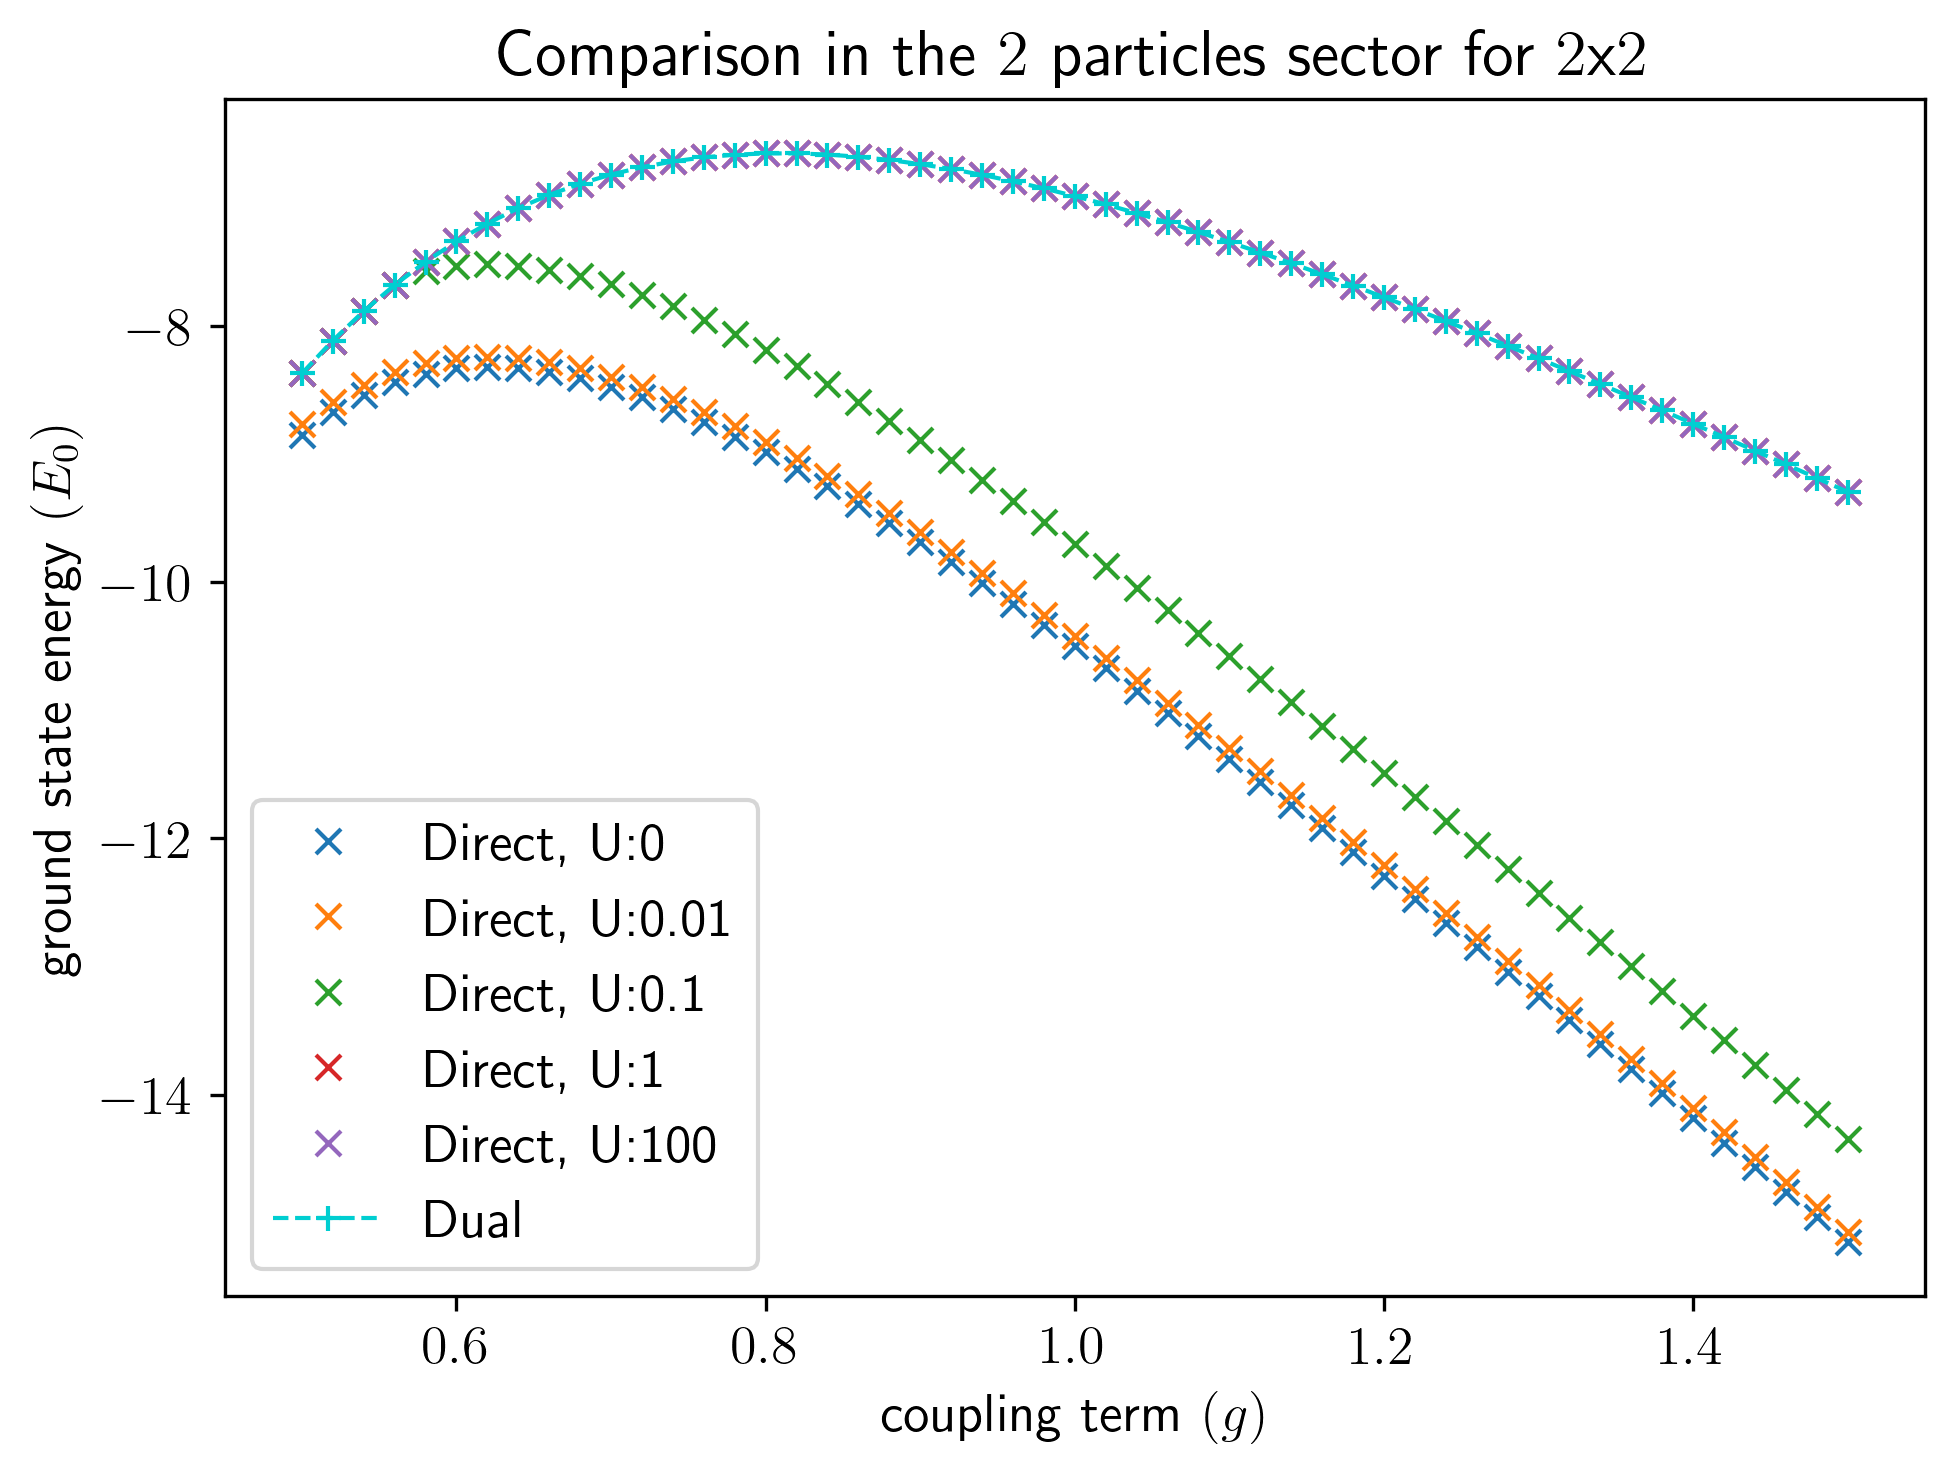

In [10]:
l, L = 2, 2
gs = np.linspace(0.5,1.5,51)
cx = [0,L]
cy = [l//2,l//2]
# cx = []
# cy = []

e_dual = []
for g in gs:
    H_dual = dual_ham(l,L,g,cx,cy)
    e,v = diagonalization(H_dual, sparse=True)
    e_dual.append(e[0])

Us = [0, 0.01, 0.1 , 1, 100]
for U in Us:
    e_dir = []
    for g in gs:
        print(f"Computing g: {g}")
        H_dir = direct_ham(l,L,g,U,cx,cy)
        e,v = diagonalization(H_dir, sparse=True)
        e_dir.append(e[0])

    plt.plot(gs,e_dir, 'x', label=f"Direct, U:{U}")
plt.plot(gs,e_dual, '+', linestyle='--', color='darkturquoise', linewidth=1, label="Dual")
if len(cx) == 0:
    plt.title(f"Comparison in the vacuum sector for ${l}$x${L}$")
else:    
    plt.title(f"Comparison in the $2$ particles sector for ${l}$x${L}$")
plt.xlabel("coupling term $(g)$")
plt.ylabel("ground state energy $(E_0)$")
plt.legend()

## MPO construction

In [11]:
def mpo_skeleton(l, aux_dim: int=None):
    """
    mpo_skeleton

    This function initializes the mpo tensor or shape (2+l,2+l,2**l,2**l)
    with O matrices. We add as well the identities in the first and last
    element of the mpo tensor.

    aux_dim: int - This auxiliary dimension represents how many rows and 
                columns we want in our MPO. By default None means that it adapts
                to the system under study. Fixing the auxiliary dimension is
                useful for known observables which will not need larger MPOs
    """
    I = identity(2**l, dtype=complex)
    O = csc_array((2**l, 2**l), dtype=complex)
    if aux_dim == None:
        skeleton = np.array(
            [[O.toarray() for i in range(2 + l)] for j in range(2 + l)]
        )
    else:
        skeleton = np.array(
            [[O.toarray() for i in range(aux_dim)] for j in range(aux_dim)]
        )
    skeleton[0, 0] = I.toarray()
    skeleton[-1, -1] = I.toarray()
    mpo = skeleton
    return mpo

def MPOPeriodicBoundaryConditions(l,L,g, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*L + 1

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = np.prod(charges, axis=1).tolist()

    # initialize
    mpo = mpo_skeleton(l)
    mpo_list = []
    for mpo_site in range(L):
        # first row, for the zz horizontal interactions
        for n in range(l):
            mpo[0, n+1] = sparse_pauli_z(n=n, L=l).toarray()
        # last column, for the zz horizontal interactions
        for n in range(l):
            mpo[n+1, -1] = - g * sparse_pauli_z(n=n, L=l).toarray()
        # first row last column, for the "local" zz vertical interaction
        for n in range(l):
            coeff = np.prod(charges[(n+1)%l,:mpo_site+1])
            mpo[0,-1] += - g * coeff * (sparse_pauli_z(n=n, L=l).toarray() @ sparse_pauli_z(n=(n+1)%l, L=l).toarray())
        # first row last column, for the local z vertical terms on the left boundary
        if mpo_site == 0:
            for n in range(l):
                mpo[0,-1] += - g * sparse_pauli_z(n=n, L=l).toarray()
        # first row last column, for the local x plaquette terms
        for n in range(l):
            mpo[0,-1] += - 1/g * sparse_pauli_x(n=n, L=l).toarray()
    
        mpo_list.append(mpo)
        mpo = mpo_skeleton(l)
        
    # last column, add the extra degree of freedom with depends on the charges
    mpo = mpo_skeleton(1, aux_dim=(l+2))
    for n in range(l):
        coeff = np.prod(prod_charges[:n+1])
        mpo[n+1, -1] = - g * coeff * sparse_pauli_z(n=0, L=1).toarray()
    mpo_list.append(mpo)

    return mpo_list


def MPOPeriodicBoundaryConditionsTopo(l,L,g, cx: list=[], cy: list=[], topological_sector: int = 1):
    # degrees of freedom
    dof = l*L + 1

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = np.prod(charges, axis=1).tolist()

    # initialize
    mpo = mpo_skeleton(l)
    mpo_list = []
    for mpo_site in range(L):
        # first row, for the zz horizontal interactions
        for n in range(l):
            mpo[0, n+1] = sparse_pauli_z(n=n, L=l).toarray()
        # last column, for the zz horizontal interactions
        for n in range(l):
            mpo[n+1, -1] = - g * sparse_pauli_z(n=n, L=l).toarray()
        # first row last column, for the "local" zz vertical interaction
        for n in range(l):
            coeff = np.prod(charges[(n+1)%l,:mpo_site+1])
            mpo[0,-1] += - g * coeff * (sparse_pauli_z(n=n, L=l).toarray() @ sparse_pauli_z(n=(n+1)%l, L=l).toarray())
        # first row last column, for the local z vertical terms on the left boundary
        if mpo_site == 0:
            for n in range(l):
                mpo[0,-1] += - g * sparse_pauli_z(n=n, L=l).toarray()
        # first row last column, for the local x plaquette terms
        for n in range(l):
            mpo[0,-1] += - 1/g * sparse_pauli_x(n=n, L=l).toarray()
    
        ## Vertical Right ----------------------------------------------
        # last column, treat it as a local term with charge coefficient
        if mpo_site == (L - 1): 
            for n in range(l):
                coeff = np.prod(prod_charges[: n + 1])
                mpo[0, -1] += (
                        -g
                        * topological_sector
                        * coeff 
                        * sparse_pauli_z(n=n, L=l).toarray()
                    )
        mpo_list.append(mpo)
        mpo = mpo_skeleton(l)
    return mpo_list


In [12]:
l, L = 3, 2
charges = np.ones((l,L+1))
charges[l//2,0] = -1
charges[l//2,L] = -1
print(charges)
prod_charges = np.prod(charges, axis=1).tolist()
for mpo_site in range(L):
    for n in range(l):
        print(np.prod(charges[(n+1)%l,:mpo_site+1]), ((n+1)%l, mpo_site))


[[ 1.  1.  1.]
 [-1.  1. -1.]
 [ 1.  1.  1.]]
-1.0 (1, 0)
1.0 (2, 0)
1.0 (0, 0)
-1.0 (1, 1)
1.0 (2, 1)
1.0 (0, 1)


In [13]:
from qs_mps.utils import mpo_to_matrix, tensor_shapes
# from qiskit.quantum_info import SparsePauliOp

l, L = 2, 2
g = 1
mpo_pbc = MPOPeriodicBoundaryConditions(l,L,g)
H = mpo_to_matrix(mpo_pbc)
e,v = diagonalization(H, sparse=True)
print(e)

[-10.50233679]


In [14]:
tensor_shapes(mpo_pbc)

(4, 4, 4, 4)
(4, 4, 4, 4)
(4, 4, 2, 2)


[(4, 4, 4, 4), (4, 4, 4, 4), (4, 4, 2, 2)]

## Comparison MPO with Exact Direct and Exact Dual

Computing g: 0.5
Computing g: 0.52
Computing g: 0.54
Computing g: 0.56
Computing g: 0.58
Computing g: 0.6
Computing g: 0.62
Computing g: 0.64
Computing g: 0.66
Computing g: 0.6799999999999999
Computing g: 0.7
Computing g: 0.72
Computing g: 0.74
Computing g: 0.76
Computing g: 0.78
Computing g: 0.8
Computing g: 0.8200000000000001
Computing g: 0.8400000000000001
Computing g: 0.86
Computing g: 0.88
Computing g: 0.9
Computing g: 0.9199999999999999
Computing g: 0.94
Computing g: 0.96
Computing g: 0.98
Computing g: 1.0
Computing g: 1.02
Computing g: 1.04
Computing g: 1.06
Computing g: 1.08
Computing g: 1.1
Computing g: 1.12
Computing g: 1.1400000000000001
Computing g: 1.1600000000000001
Computing g: 1.1800000000000002
Computing g: 1.2000000000000002
Computing g: 1.22
Computing g: 1.24
Computing g: 1.26
Computing g: 1.28
Computing g: 1.3
Computing g: 1.32
Computing g: 1.3399999999999999
Computing g: 1.3599999999999999
Computing g: 1.38
Computing g: 1.4
Computing g: 1.42
Computing g: 1.44
Compu

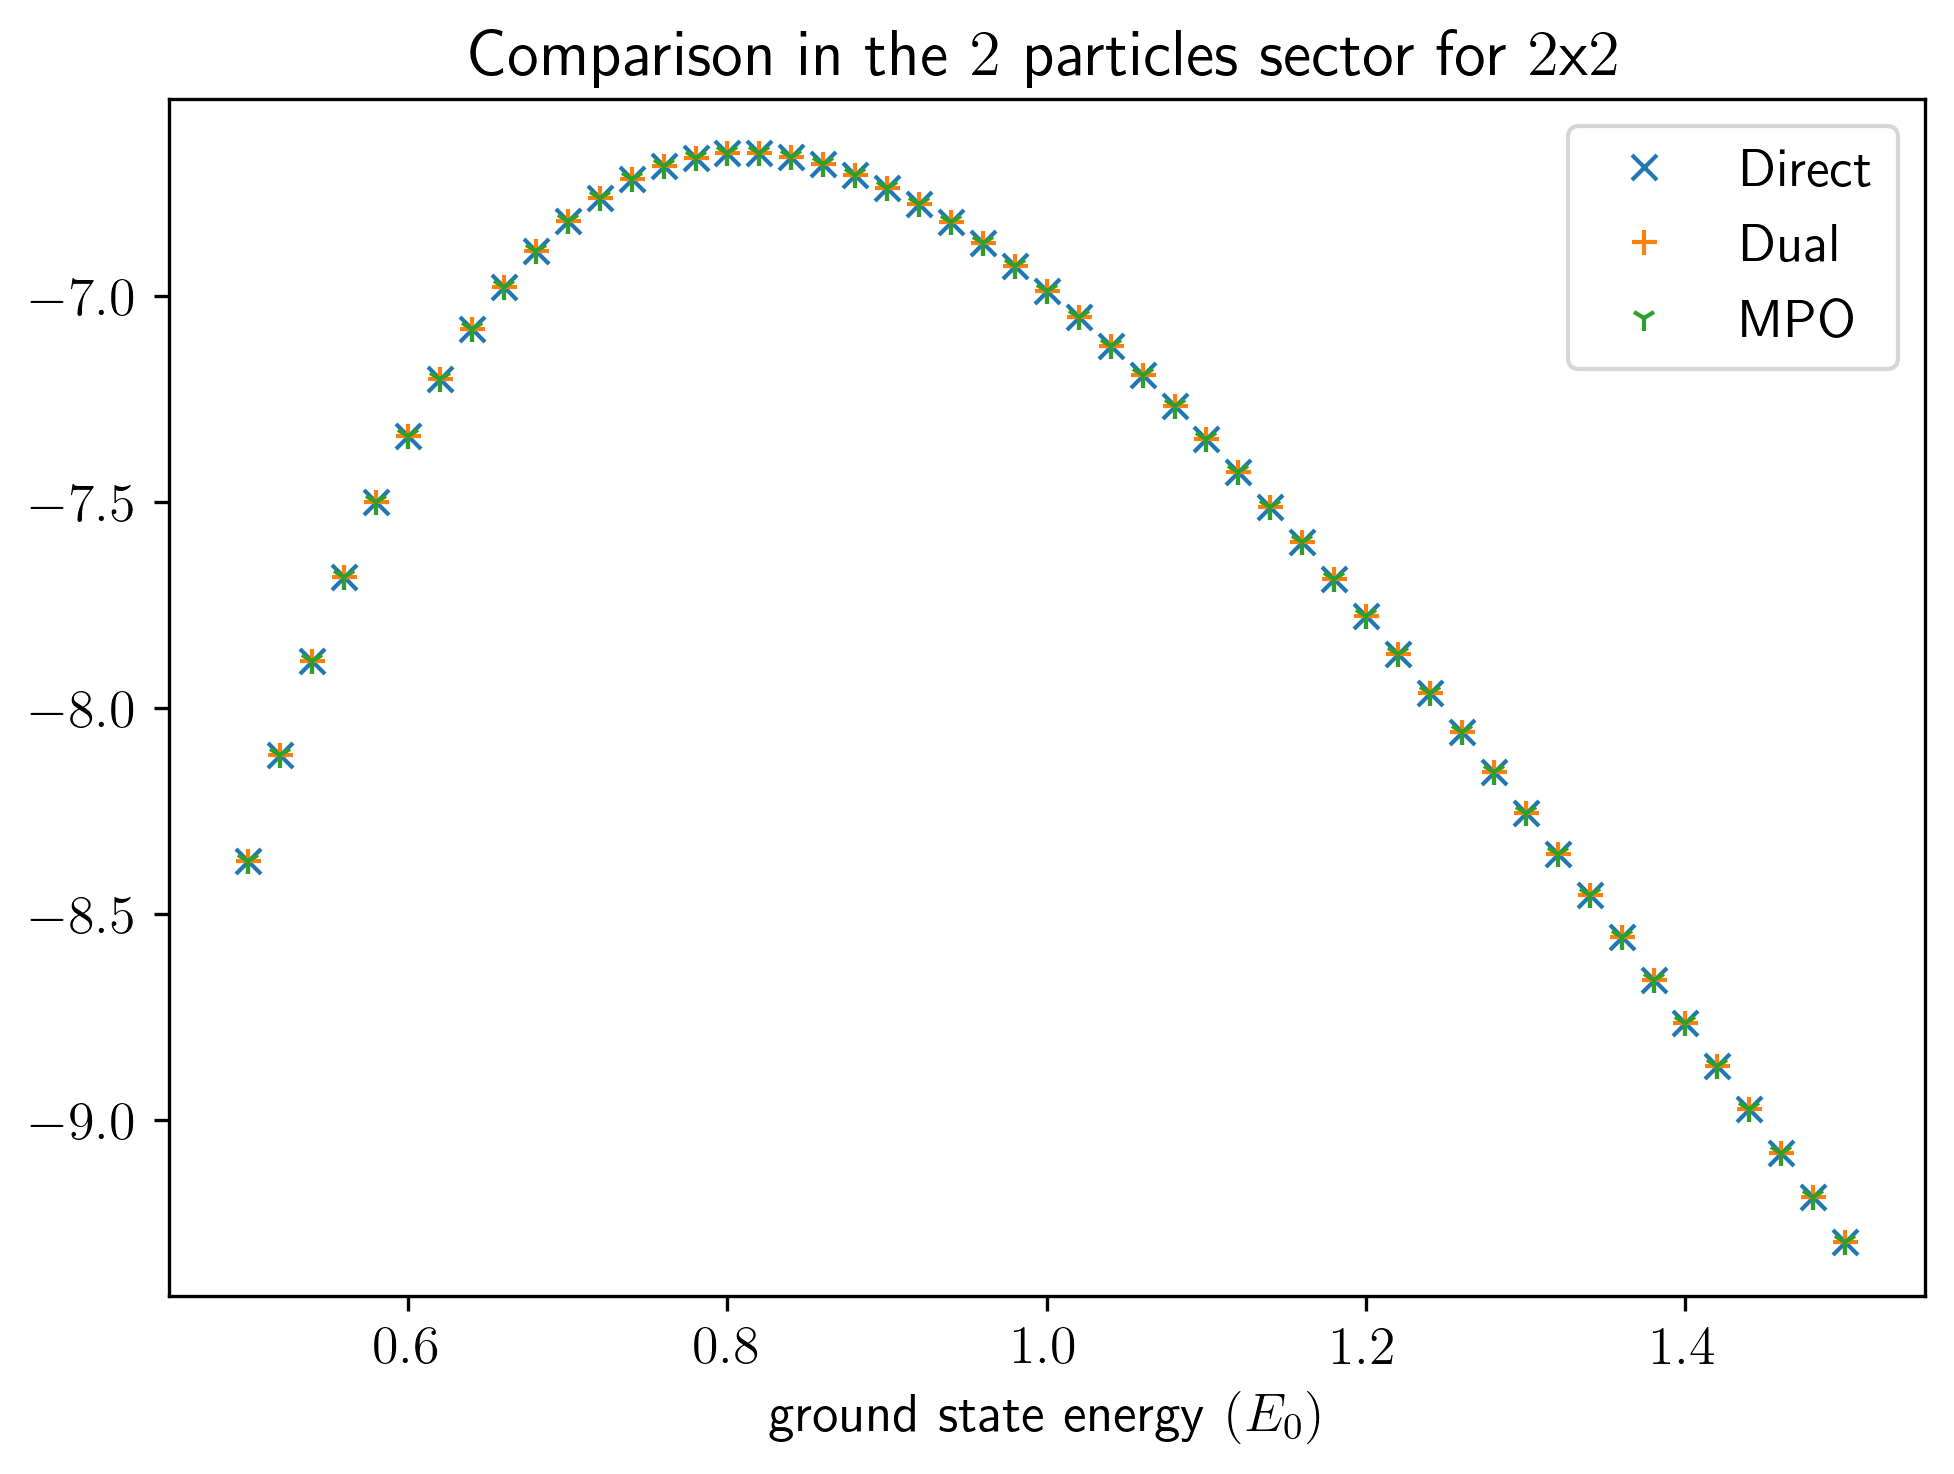

In [15]:
l, L = 2, 2
gs = np.linspace(0.5,1.5,51)
e_dir = []
e_dual = []
e_mpo = []
cx = [0,L]
cy = [l//2,l//2]
# cx = []
# cy = []
for g in gs:
    print(f"Computing g: {g}")
    H_dual = dual_ham(l,L,g,cx,cy)
    e,v = diagonalization(H_dual, sparse=True)
    e_dual.append(e[0])
    H_dir = direct_ham(l,L,g,Us[-1],cx,cy)
    e,v = diagonalization(H_dir, sparse=True)
    e_dir.append(e[0])
    mpo_pbc = MPOPeriodicBoundaryConditions(l,L,g,cx,cy)
    H_mpo = mpo_to_matrix(mpo_pbc)
    e,v = diagonalization(H_mpo, sparse=True)
    e_mpo.append(e[0])

plt.plot(gs,e_dir, 'x', label="Direct")
plt.plot(gs,e_dual, '+', label="Dual")
plt.plot(gs,e_mpo, '1', label="MPO")
if len(cx) == 0:
    plt.title(f"Comparison in the vacuum sector for ${l}$x${L}$")
else:    
    plt.title(f"Comparison in the $2$ particles sector for ${l}$x${L}$")
plt.xlabel("coupling term $(g)$")
plt.xlabel("ground state energy $(E_0)$")
plt.legend()

## Exact $vs$ Dual $vs$ DMRG

In [16]:
l, L = 2, 2
gs = np.linspace(0.1,2.0,51)
e_dir = []
e_dual = []
e_dmrg = []
cx = [0,L]
cy = [l//2,l//2]
# cx = []
# cy = []
d = 2**l
chi = 4
type_shape = "trapezoidal"
model = "Z2_dual"
bc = "pbc"
where = L//2
bond = True
path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
precision = 2
if len(cx) == 0:
    sector = "vacuum_sector"
else:
    sector = f"{len(cx)}_particle(s)_sector"

print(sector)

save = False
number_sweeps = 8
conv_tol = 1e-15
training = False
init_tensor = []
args_mps = {
            "L": L,
            "d": d,
            "chi": chi,
            "type_shape": type_shape,
            "model": model,
            "trunc_tol": False,
            "trunc_chi": True,
            "where": where,
            "bond": bond,
            "path": path_tensor,
            "save": save,
            "precision": precision,
            "sector": sector,
            "charges_x": cx,
            "charges_y": cy,
            "n_sweeps": number_sweeps,
            "conv_tol": conv_tol,
            "training": training,
            "guess": init_tensor,
            "bc": bc
        }

ancillas = []
for g in gs:
    print(f"Computing g: {g}")
    H_dual = dual_ham(l,L,g,cx,cy)
    e,v = diagonalization(H_dual, sparse=True)
    e_dual.append(e[0])
    H_dir = direct_ham(l,L,g,Us[-1],cx,cy)
    e,v = diagonalization(H_dir, sparse=True)
    e_dir.append(e[0])
    
    mps = MPS(L=L,d=d, h=g, model=args_mps["model"],
        chi=args_mps["chi"], bc=bc)
    save = args_mps["save"]
    precision = args_mps["precision"]
    if mps.model == "Z2_dual":
        # mps.L = mps.L - 1
        if args_mps["sector"] != "vacuum_sector":
            mps.Z2.add_charges(rows=args_mps["charges_x"], columns=args_mps["charges_y"])
            print(mps.Z2.charges)
    # if args_mps["sector"] != "vacuum_sector":
    #     mps.Z2.add_charges(rows=args_mps["charges_x"], columns=args_mps["charges_y"])
    #     print(mps.Z2.charges)
    if args_mps["guess"] == []:
        mps._random_state(seed=3, chi=args_mps["chi"], type_shape=args_mps["type_shape"])
        mps.canonical_form(trunc_chi=True, trunc_tol=False)
        if mps.bc == "pbc":
            a = np.zeros((1,2))
            a[0,0] = 1
            # a[0,0] = 1/np.sqrt(2)
            # a[0,1] = 1/np.sqrt(2)
            extra_ancillary_site = a.reshape((1,2,1))
            mps.sites.append(extra_ancillary_site)
            mps.L = len(mps.sites)
            tensor_shapes(mps.sites)

    # else:
    #     mps.sites = args_mps["guess"].copy()
    #     mps.enlarge_chi()

    energy, entropy, schmidt_vals, t_dmrg = mps.DMRG(
        trunc_tol=args_mps["trunc_tol"],
        trunc_chi=args_mps["trunc_chi"],
        where=args_mps["where"],
        bond=args_mps["bond"],
        n_sweeps=args_mps["n_sweeps"],
        conv_tol=args_mps["conv_tol"]
    )

    print(f"energy of h:{g:.{precision}f}, L:{mps.L} is:\n {energy}")
    print(f"Schmidt values in the middle of the chain:\n {schmidt_vals}")
    
    if not args_mps["training"]:
        energy = energy[-1]

    e_dmrg.append(energy)
    ancillas.append(mps.sites[-1].reshape((2,1)))
    
plt.plot(gs,e_dir, 'x', label="Direct")
plt.plot(gs,e_dual, '+', label="Dual")
plt.plot(gs,e_dmrg, '1', label="MPO")
if len(cx) == 0:
    plt.title(f"Comparison in the vacuum sector for ${l}$x${L}$")
else:
    plt.title(f"Comparison in the $2$ particles sector for ${l}$x${L}$")
plt.xlabel("coupling term $(g)$")
plt.ylabel("ground state energy $(E_0)$")
plt.legend()

2_particle(s)_sector
Computing g: 0.1
[[ 1.  1.  1.]
 [-1.  1. -1.]]
(1, 4, 4)
(4, 4, 1)
(1, 2, 1)


IndexError: list index out of range

In [ ]:
for ancilla in ancillas:
    Z_logic = sparse_pauli_z(n=0,L=1)
    thooft = (ancilla.T.conjugate() @ Z_logic @ ancilla).real
    print(thooft)

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]


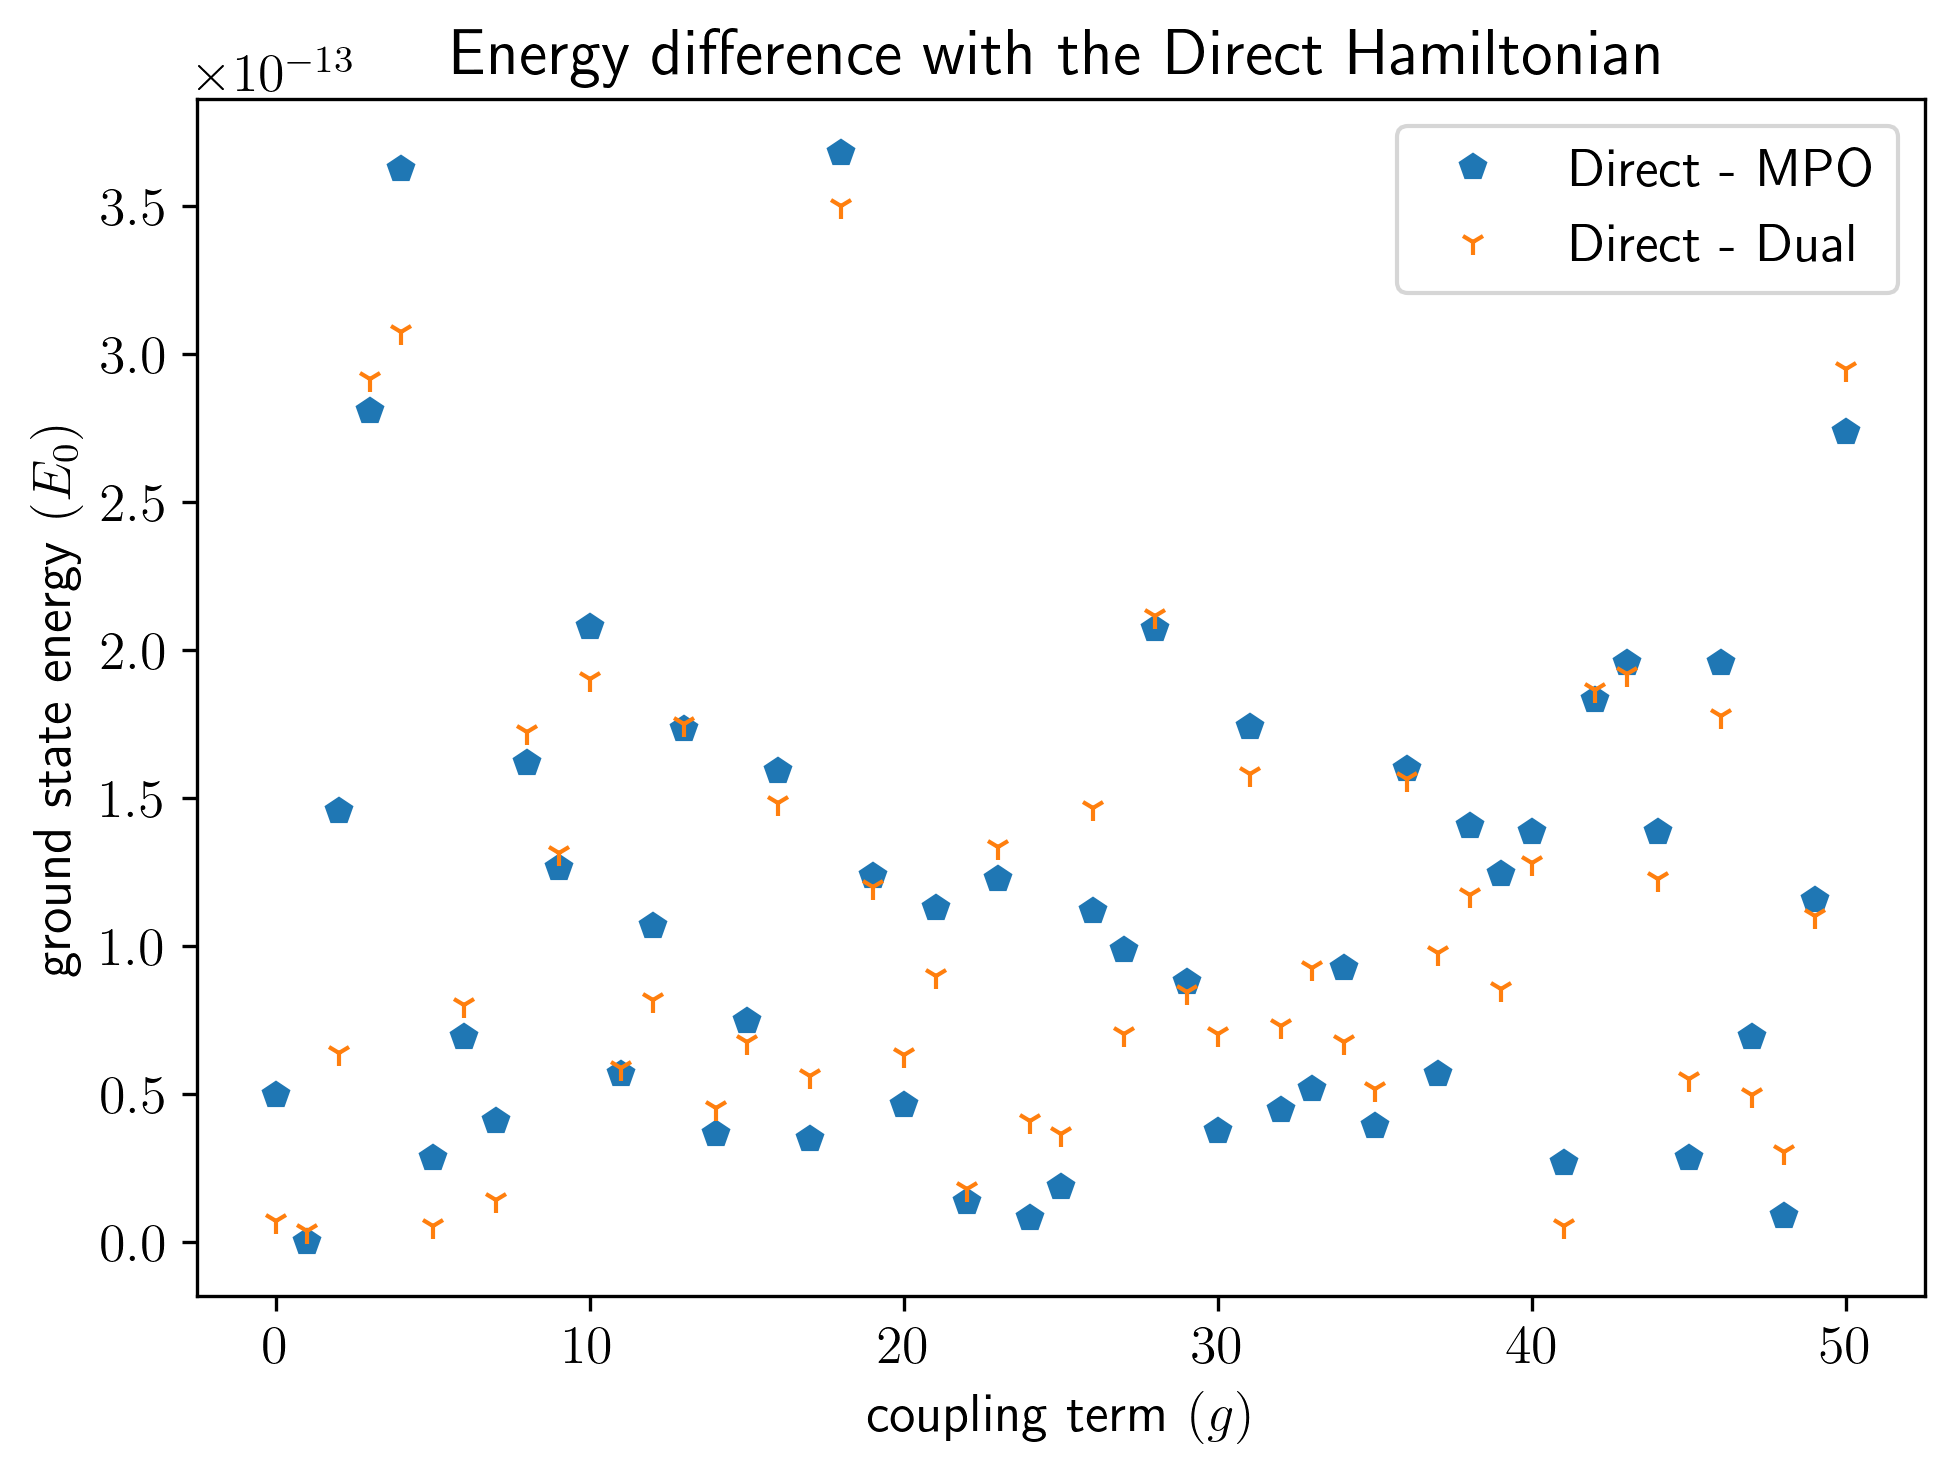

In [ ]:
plt.title("Energy difference with the Direct Hamiltonian")
plt.plot(np.abs(np.asarray(e_dmrg)-np.asarray(e_dir)), 'p', label="Direct - MPO")
plt.plot(np.abs(np.asarray(e_dual)-np.asarray(e_dir)), '1', label="Direct - Dual")
plt.xlabel("coupling term $(g)$")
plt.ylabel("ground state energy $(E_0)$")
plt.legend()

In [ ]:
l, L = 3, 3
gs = np.linspace(0.8,1.0,10)
cx = [0,3]
cy = [1,1]
# cx = []
# cy = []

e_dual = []
e_dmrg = []
for g in gs:
    H_dual = dual_ham(l,L,g,cx,cy)
    e,v = diagonalization(H_dual, sparse=True)
    e_dual.append(e[0])

e_dmrg = np.load('/Users/fradm/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/energy_data/energy_Z2_dual_direct_lattice_3x3_2_particle(s)_sector_bc_pbc_[0, 3]-[1, 1]_h_0.8-1.0_delta_10_chi_8.npy')

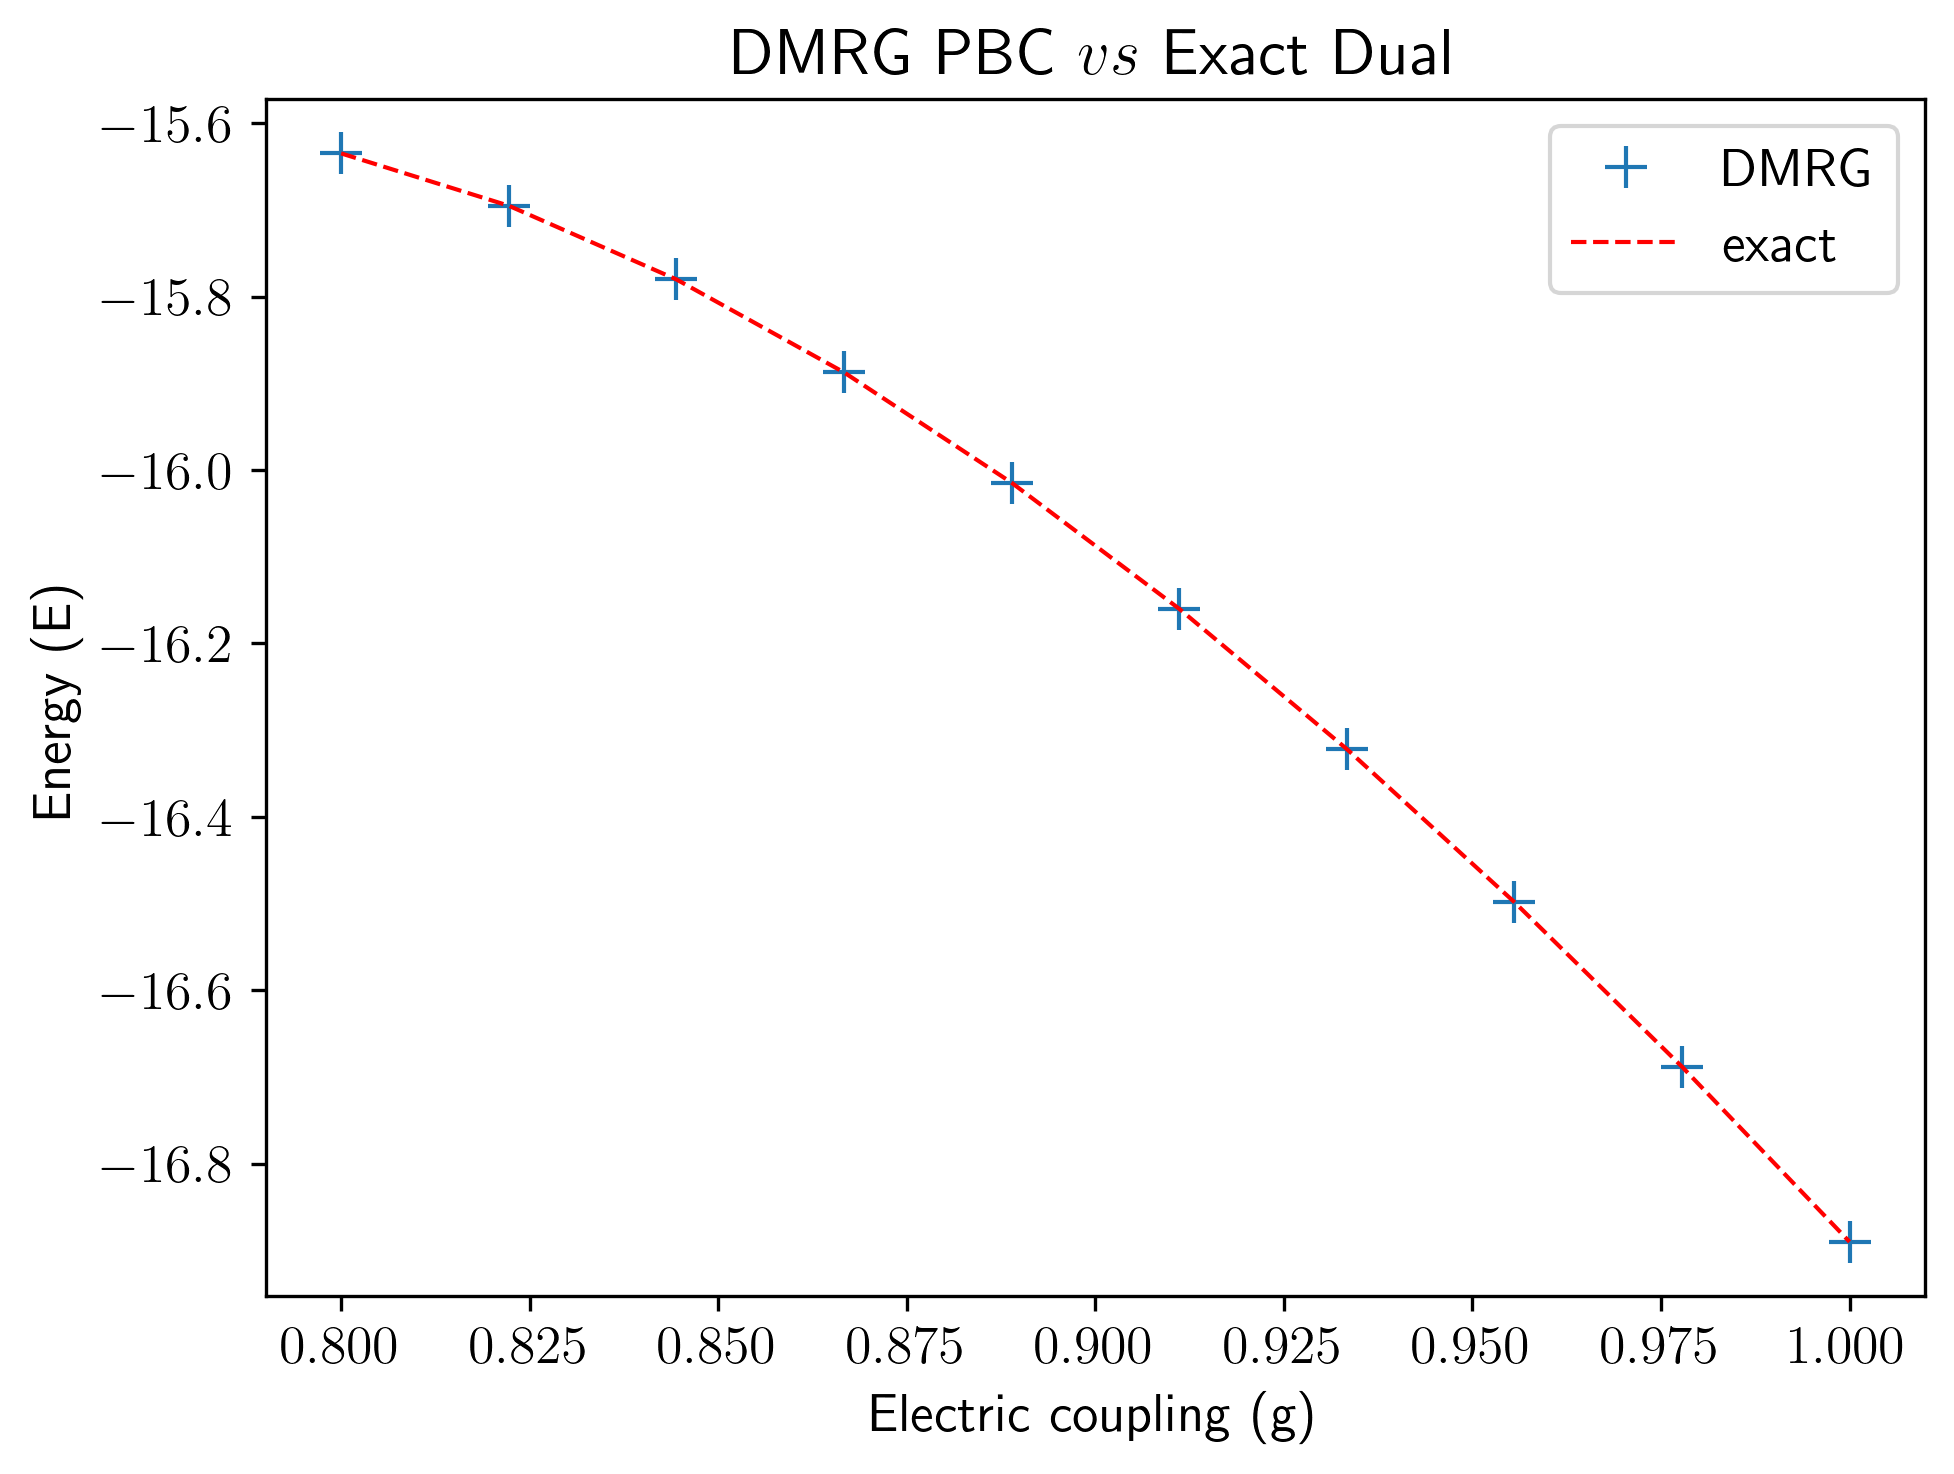

In [ ]:
plt.plot(gs, e_dmrg, marker='+', linestyle='', markersize=10, label="DMRG")
plt.plot(gs, e_dual, color='red',linestyle='--', linewidth=1, label="exact")
plt.title("DMRG PBC $vs$ Exact Dual")
plt.xlabel("Electric coupling (g)")
plt.ylabel("Energy (E)")
plt.legend()

# First Excited state

In [17]:
sparse = True
sparse = False
l, L = 2, 3
gs = np.linspace(0.1,1,10)
e_dir = []
e_dual = []
e_mpo = []
R = 0
cx = get_cx(L, R)
cy = get_cy(l, bc, R=R)
cx = []
cy = []
for g in gs:
    print(f"Computing g: {g}")
    H_dual = dual_ham(l,L,g,cx,cy)
    e,v = diagonalization(H_dual, sparse=sparse, k=6, maxiter=None)
    e_dual.append(e)
    H_dir = direct_ham(l,L,g,Us[-1],cx,cy)
    e,v = diagonalization(H_dir, sparse=sparse, k=2, maxiter=None)
    e_dir.append(e)
    # mpo_pbc = MPOPeriodicBoundaryConditions(l,L,g,cx,cy)
    mpo_pbc = MPOPeriodicBoundaryConditionsTopo(l,L,g,cx,cy,topological_sector=1)
    H_mpo = mpo_to_matrix(mpo_pbc)
    e,v = diagonalization(H_mpo, sparse=True, k=6, maxiter=None)
    e_mpo.append(e)

Computing g: 0.1
Computing g: 0.2
Computing g: 0.30000000000000004
Computing g: 0.4
Computing g: 0.5
Computing g: 0.6
Computing g: 0.7000000000000001
Computing g: 0.8
Computing g: 0.9
Computing g: 1.0


In [18]:
e_dual[0], e_dir[0][:33]

(array([-6.00060408e+01, -6.00060404e+01, -4.03470913e+01, -4.03470913e+01,
        -4.02034728e+01, -4.02034728e+01, -4.00614366e+01, -4.00614366e+01,
        -3.99442759e+01, -3.99442759e+01, -3.98035278e+01, -3.98035278e+01,
        -3.96642771e+01, -3.96642771e+01, -2.05751756e+01, -2.05751756e+01,
        -2.04264303e+01, -2.04264302e+01, -2.03054262e+01, -2.03054261e+01,
        -2.01431509e+01, -2.01431509e+01, -2.01431505e+01, -2.01431505e+01,
        -2.00025596e+01, -2.00025593e+01, -2.00024997e+01, -2.00024997e+01,
        -2.00024993e+01, -2.00024993e+01, -2.00016470e+01, -2.00016467e+01,
        -2.00015842e+01, -2.00015839e+01, -1.98603101e+01, -1.98603101e+01,
        -1.98603097e+01, -1.98603097e+01, -1.96957345e+01, -1.96957345e+01,
        -1.95779635e+01, -1.95779635e+01, -1.94315205e+01, -1.94315204e+01,
        -6.92900813e-01, -6.92900807e-01, -3.41424008e-01, -3.41423992e-01,
        -3.01921590e-01, -3.01921578e-01, -2.54866274e-01, -2.54866274e-01,
        -2.4

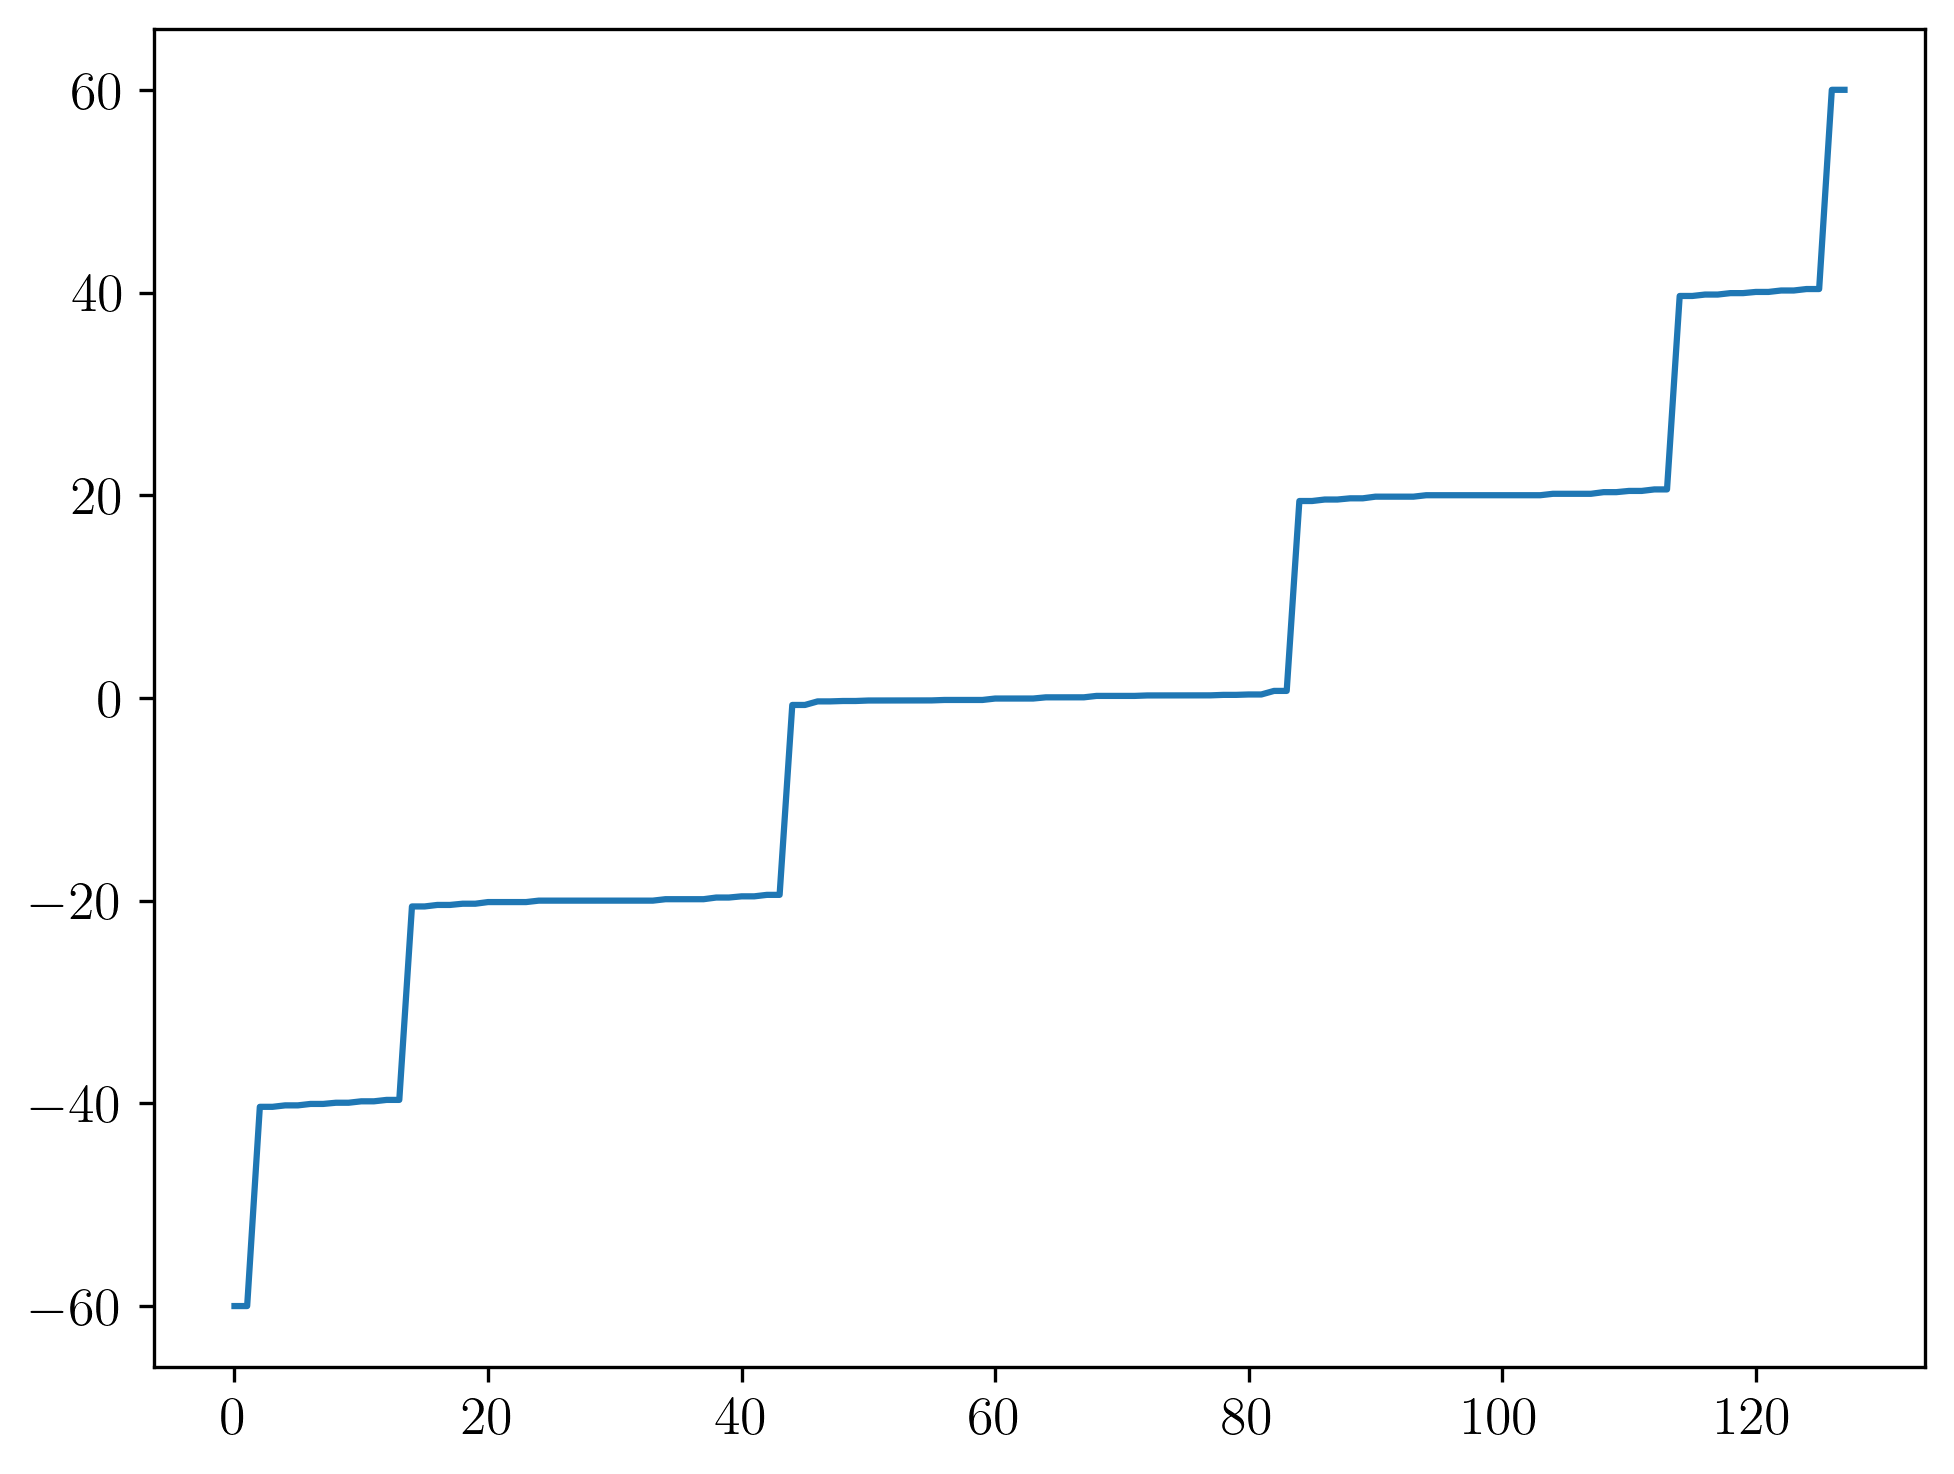

In [19]:
# plt.plot(abs(e_dual[0]))
# plt.yscale('log')
plt.plot(e_dual[0])

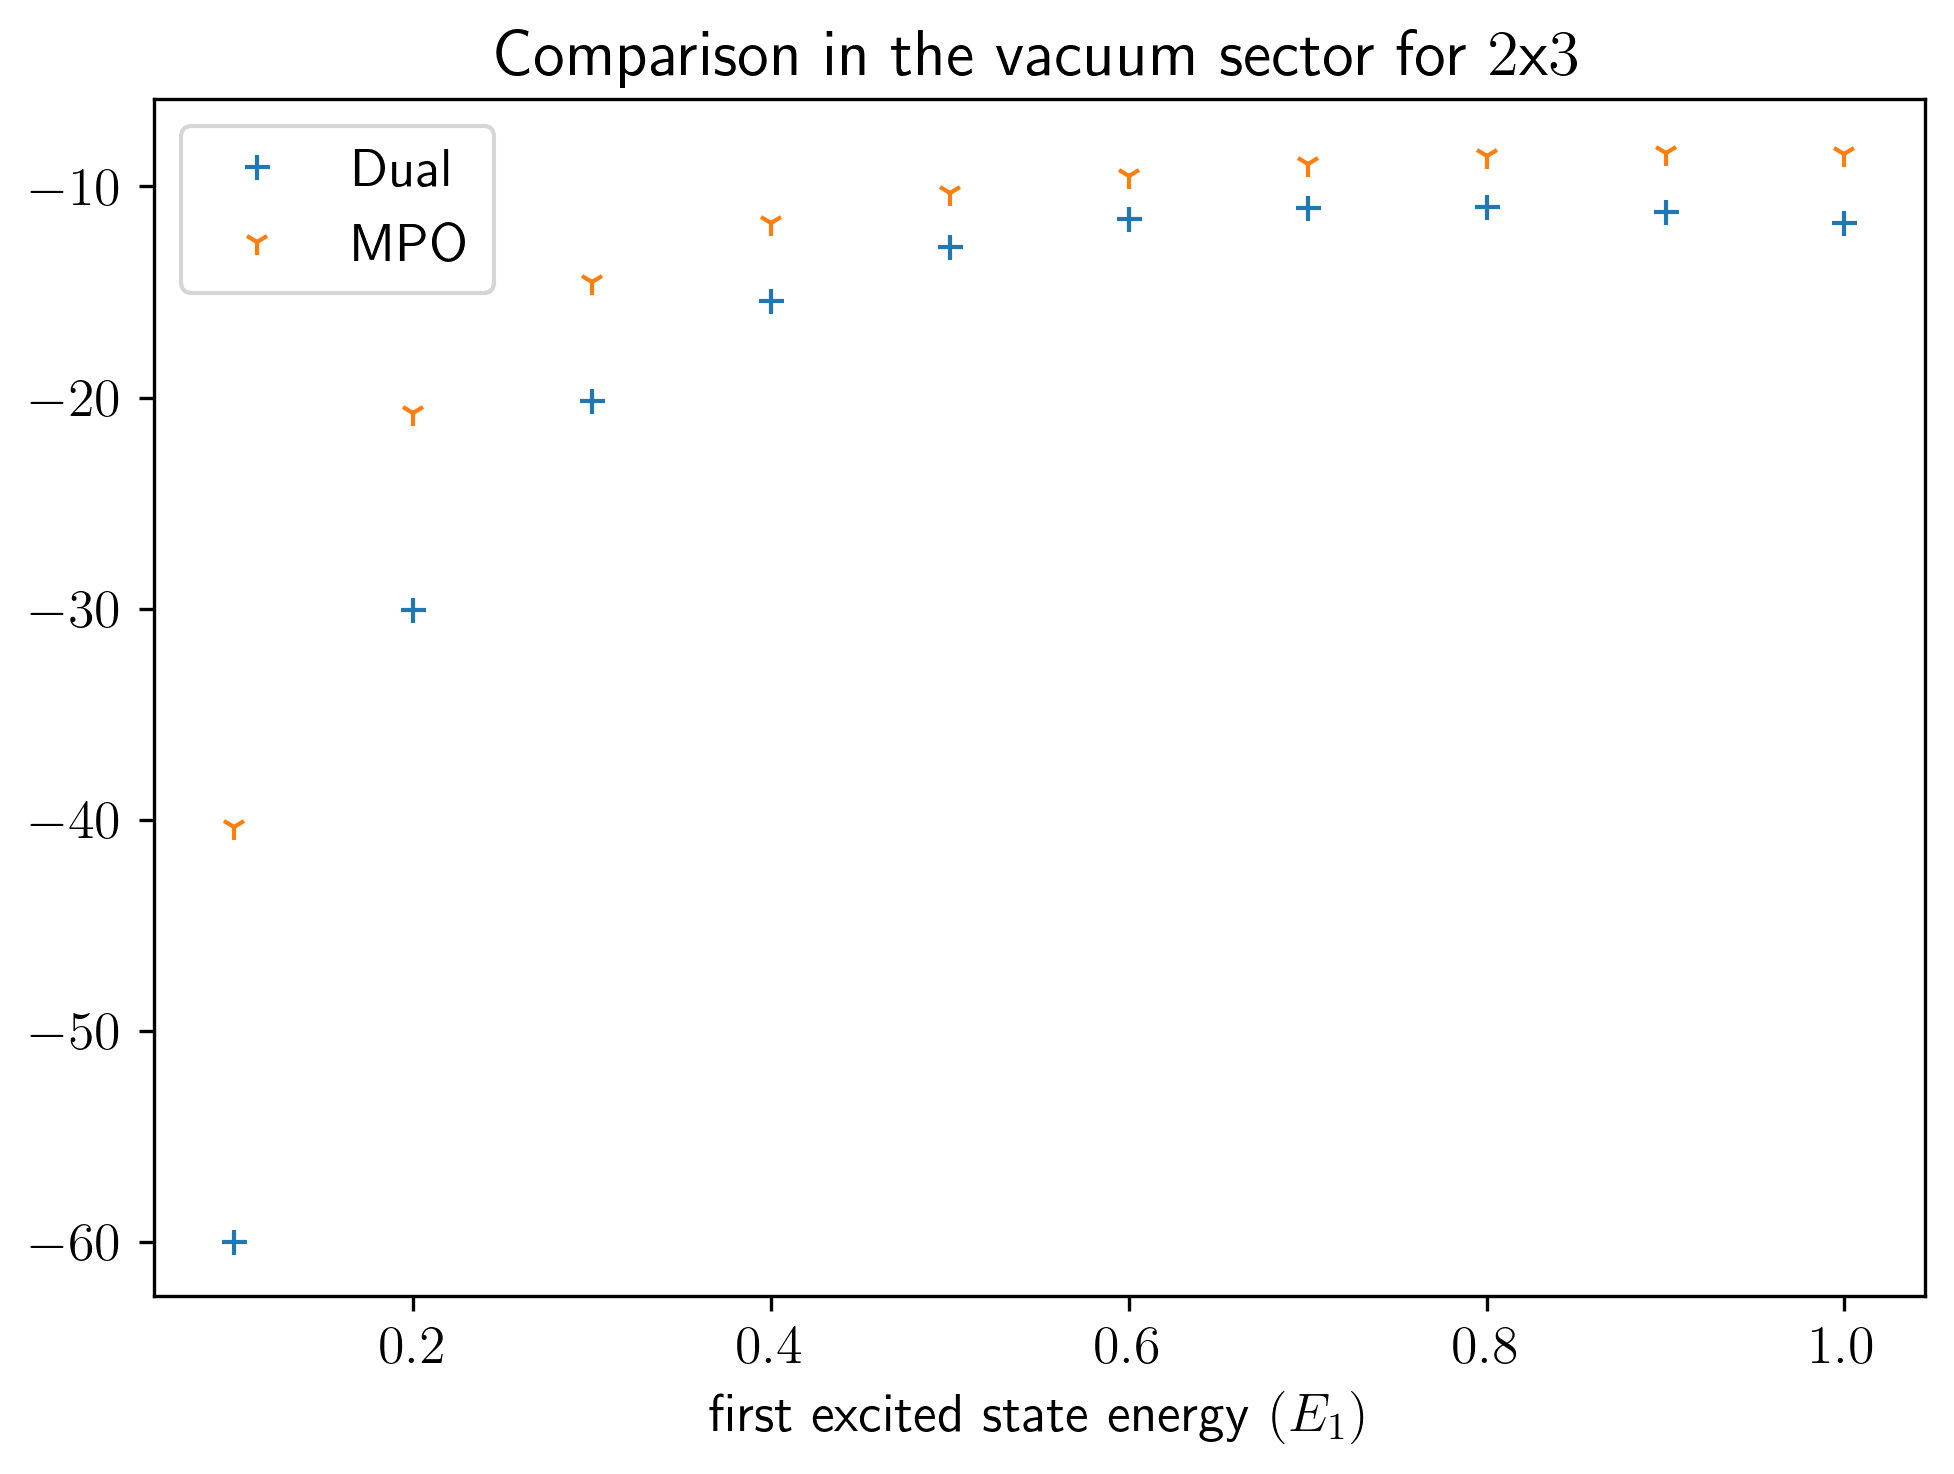

In [20]:
# plt.plot(gs,e_dir, 'x', label="Direct")
plt.plot(gs,np.asarray(e_dual)[:,1], '+', label="Dual")
plt.plot(gs,np.asarray(e_mpo)[:,1], '1', label="MPO")
if len(cx) == 0:
    plt.title(f"Comparison in the vacuum sector for ${l}$x${L}$")
else:
    plt.title(f"Comparison in the $2$ particles sector for ${l}$x${L}$")
plt.xlabel("coupling term $(g)$")
plt.xlabel("first excited state energy $(E_1)$")
plt.legend()

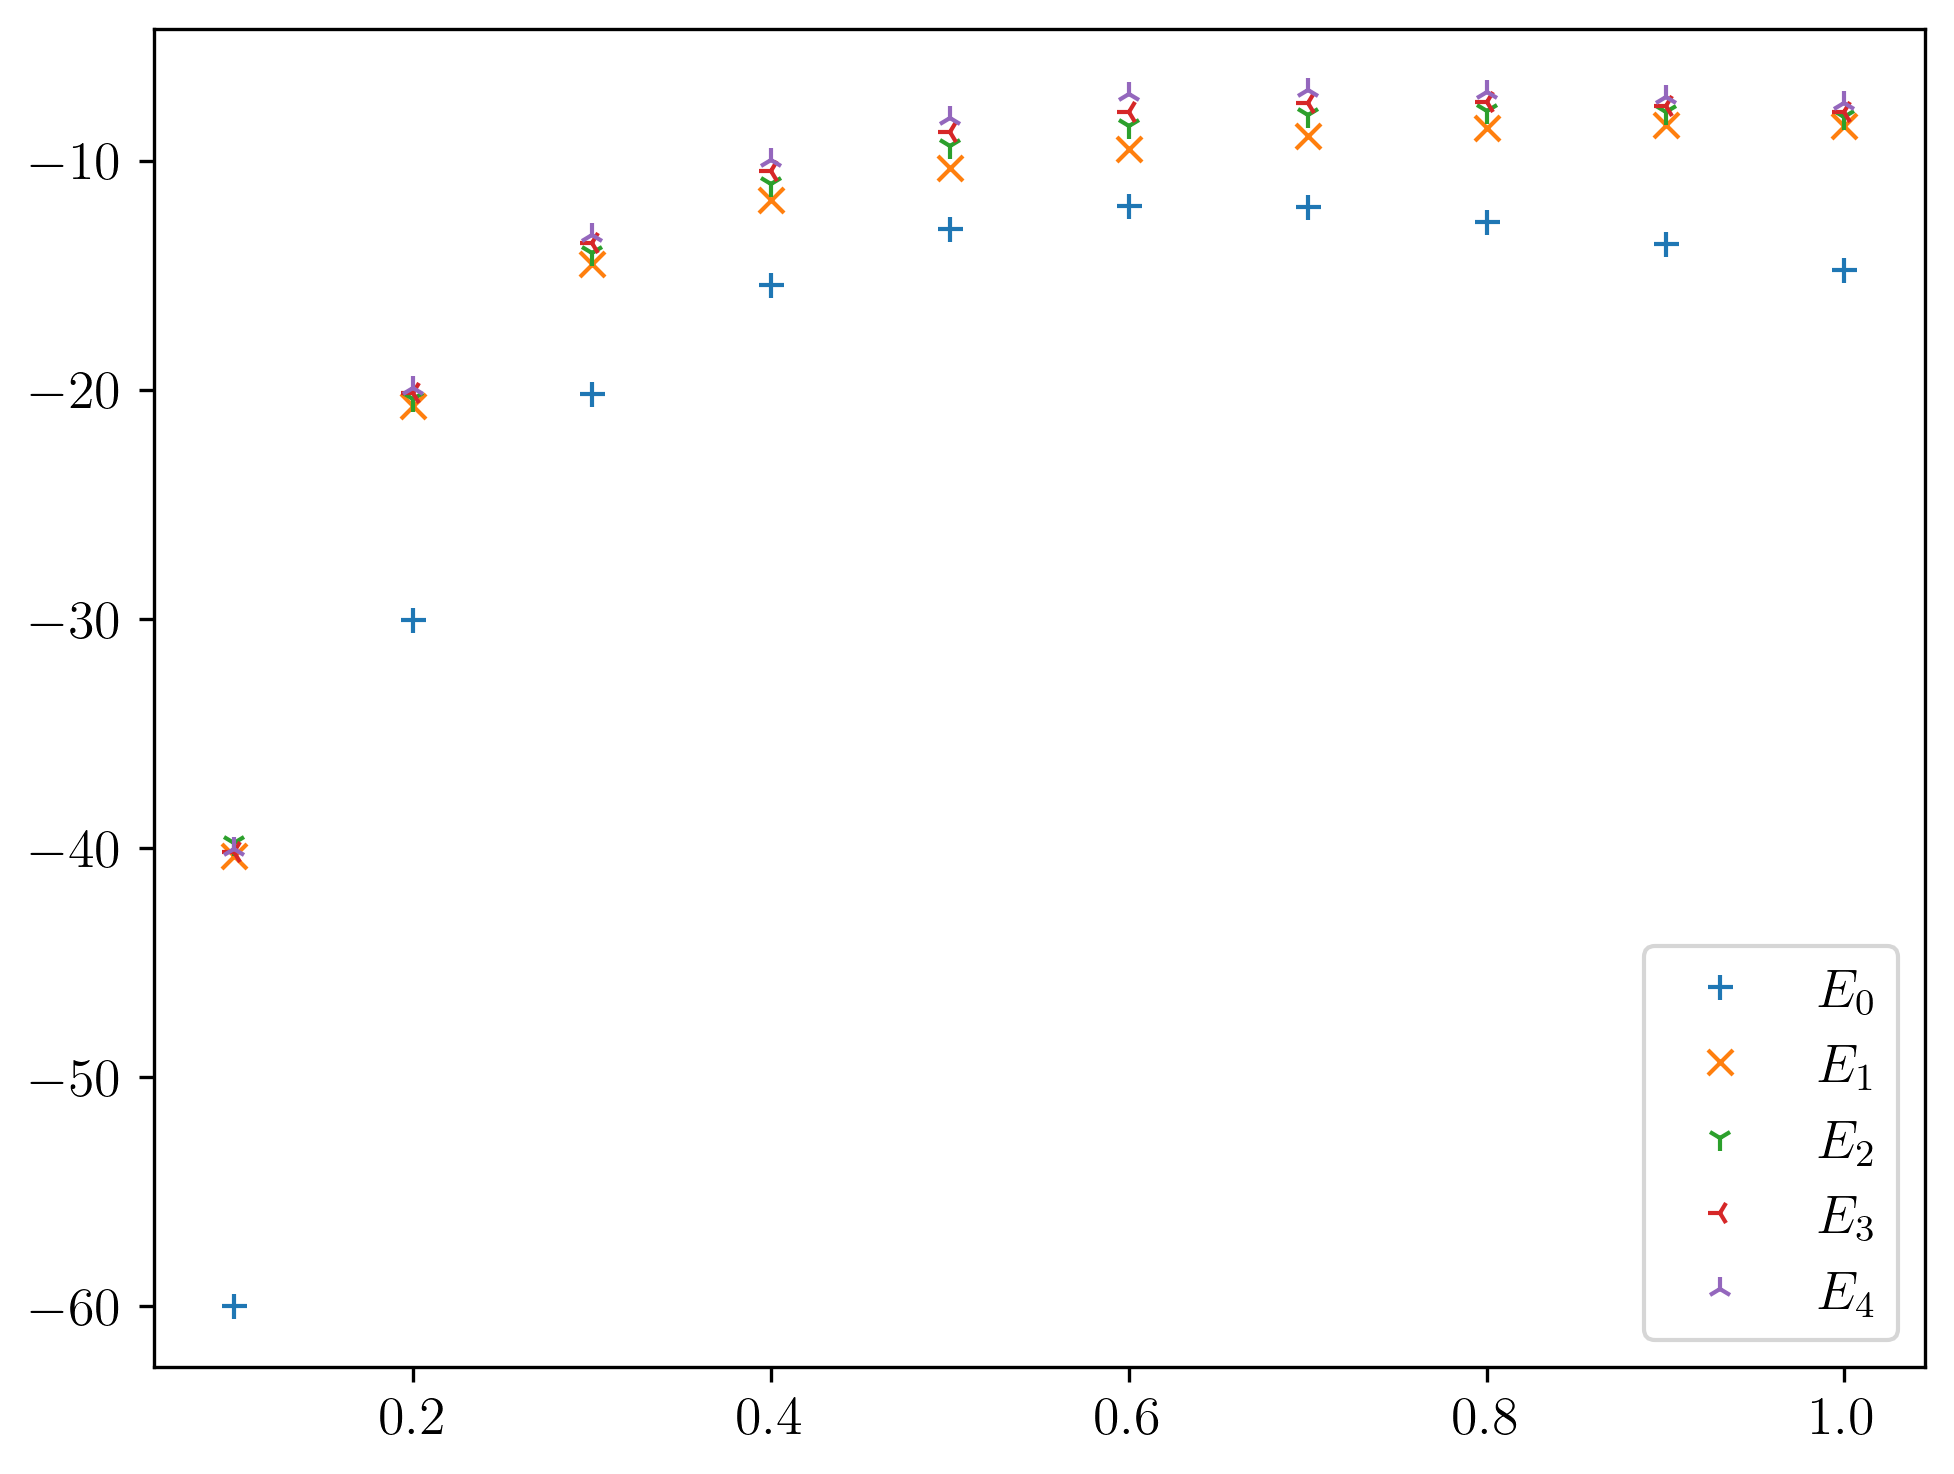

In [24]:
plt.plot(gs,np.asarray(e_mpo)[:,0], '+', label="$E_0$")
plt.plot(gs,np.asarray(e_mpo)[:,1], 'x', label="$E_1$")
plt.plot(gs,np.asarray(e_mpo)[:,2], '1', label="$E_2$")
plt.plot(gs,np.asarray(e_mpo)[:,3], '3', label="$E_3$")
plt.plot(gs,np.asarray(e_mpo)[:,4], '2', label="$E_4$")
# plt.plot(gs,np.asarray(e_mpo)[:,1], '3', label="$E_{1 plaq}$ deg: $L_x L_y$")
# plt.plot(gs,np.asarray(e_mpo)[:,L*l+1], '3', label="$E_{2 plaq}$ deg: $2 L_x L_y$")
# plt.plot(gs,np.asarray(e_mpo)[:,L+1], 'o', label="$E_{ex}$")
plt.legend()

In [22]:
np.asarray(e_mpo).shape

(10, 6)

In [133]:
np.sort(np.asarray(e_dual)[-1])
np.asarray(e_mpo)[-1,6] - np.asarray(e_mpo)[-1,0]

np.asarray(e_mpo)[-1]

array([-30.09374995, -14.07805915, -14.15622077, -14.12515092,
       -14.10912801, -14.07805915, -14.10912801,  -6.8857849 ,
        -6.88518593,  -5.16196481,  -5.16182862,  -6.18889132,
        -6.06386856,  -6.0630095 ,  -6.04681474,  -6.04744211,
        -6.0630095 ,  -6.04681474,  -6.04744211,   0.2552429 ])

### Variational orthonormal search 

In [114]:
from qs_mps.applications.Z2.ground_state_multiprocessing import ground_state_Z2_param
import datetime as dt

l, L = 2, 3
d = 2**l
h_i, h_f, npoints = 0.1, 10.0, 100
gs = np.linspace(h_i, h_f, npoints)
R = 0
cx = get_cx(L, R)
cy = get_cy(l, bc, R=R, cy=cy)
cx = np.nan
cy = np.nan
print(cx, cy)
chi = 8
sector = "vacuum_sector"
# sector = "2_particle(s)_sector"
args_mps = {
            "L": L,
            "d": d,
            "chi": chi,
            "type_shape": type_shape,
            "model": model,
            "trunc_tol": False,
            "trunc_chi": True,
            "where": where,
            "bond": bond,
            "path": path_tensor,
            "save": save,
            "precision": 3,
            "sector": sector,
            "charges_x": cx,
            "charges_y": cy,
            "n_sweeps": 8,
            "conv_tol": 1e-15,
            "training": training,
            "guess": init_tensor,
            "bc": bc,
            "cc": "h",
            "excited": True
        }

energies, entropies, schmidt_vals, times = [], [], [], []
for p in gs:
    print(f"\n*** Starting param: {p:.5f} in {dt.datetime.now()} ***\n")
    params = [args_mps, p]
    energy, entropy, schmidt_val, t_dmrg = ground_state_Z2_param(params)
    energies.append(energy)
    entropies.append(entropy)
    schmidt_vals.append(schmidt_val)
    times.append(t_dmrg)

nan nan

*** Starting param: 0.10000 in 2025-07-14 18:15:01.810413 ***

Metadata: {'L': 3, 'bc': 'pbc', 'chi': 8, 'cx': nan, 'cy': nan, 'h': 0.1, 'l': 2, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
Running with random state
Sweep n: 0

Sweep n: 1

time of the whole search for h=0.100, chi=8 is: 0:00:00.038023 in date 2025-07-14 18:15:01.856340

*** Starting param: 0.20000 in 2025-07-14 18:15:01.856372 ***

Metadata: {'L': 3, 'bc': 'pbc', 'chi': 8, 'cx': nan, 'cy': nan, 'h': 0.2, 'l': 2, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
Running with random state
Sweep n: 0

Sweep n: 1

time of the whole search for h=0.200, chi=8 is: 0:00:00.036700 in date 2025-07-14 18:15:01.898552

*** Starting param: 0.30000 in 2025-07-14 18:15:01.898570 ***

Metadata: {'L': 3, 'bc': 'pbc', 'chi': 8, 'cx': nan, 'cy': nan, 'h': 0.30000000000000004, 'l': 2, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
Running with random state
Sweep n: 0

Sweep n: 1

time of the whole search for h=0.300, chi=8 is: 0:0

In [115]:
try:
    e0_mps = np.load(f"{path_tensor}/results/energy_data/energy_{model}_direct_lattice_{l}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
except:
    e0_mps = np.load(f"{path_tensor}/results/energy_data/energy_{model}_direct_lattice_{l}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")

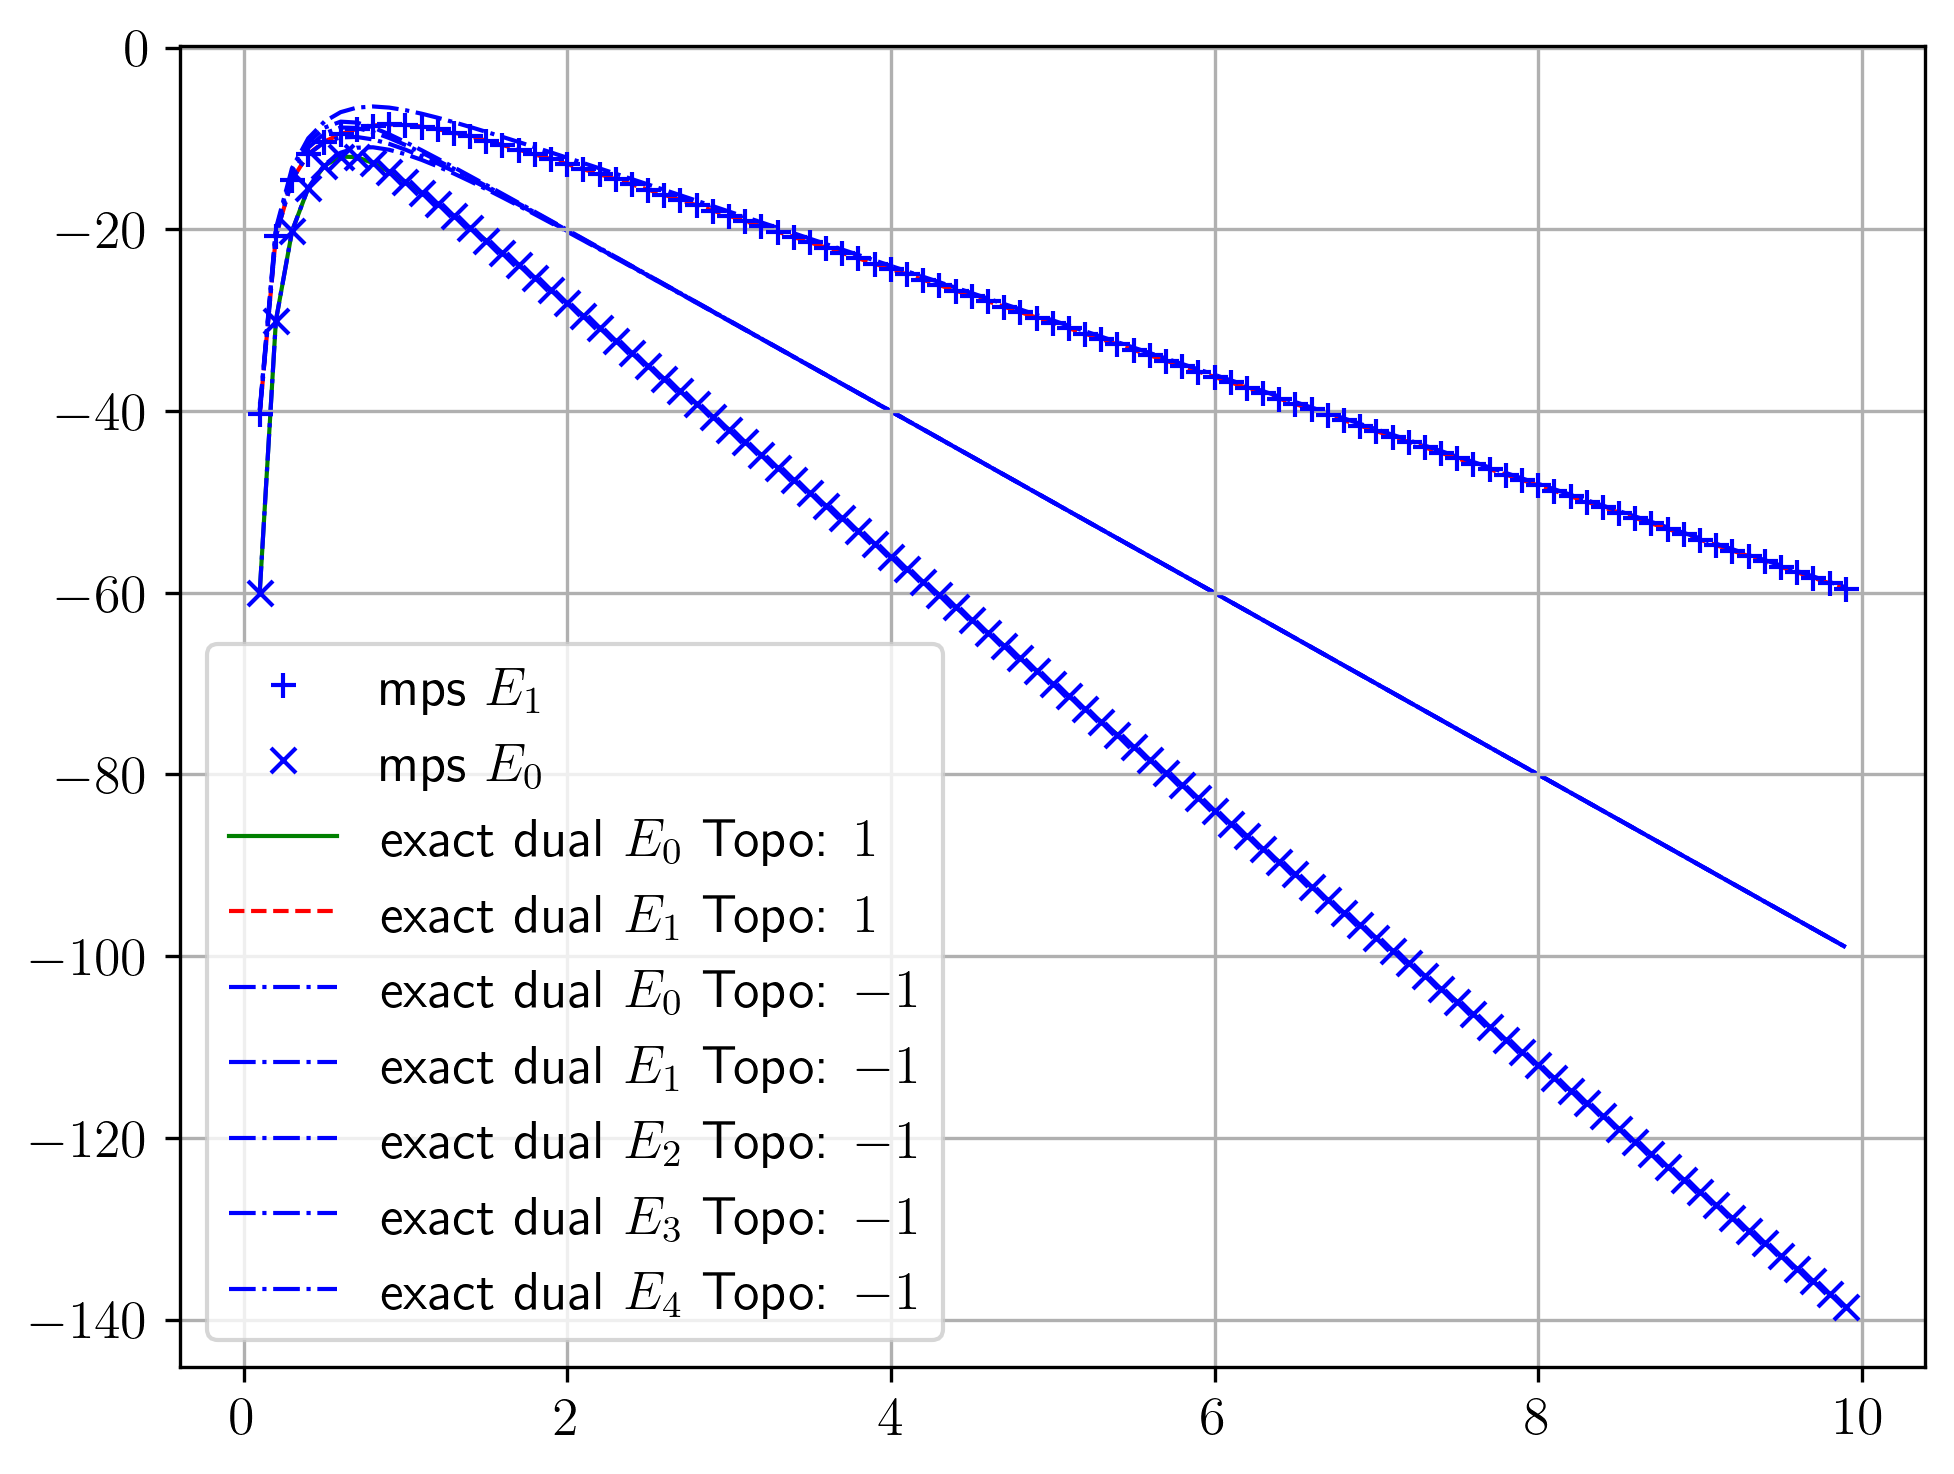

In [ ]:
idx = -1
plt.plot(gs[0:idx], energies[0:idx], '+', color='blue', label="mps $E_1$")
plt.plot(gs[0:idx], e0_mps[0:idx], 'x', color='blue', label="mps $E_0$")
# plt.plot(gs, np.asarray(e_dir)[:,0], label="exact direct $E_0$", linewidth=1, color='red', zorder=0)
# plt.plot(gs, np.asarray(e_dir)[:,1], label="exact direct $E_1$", linewidth=1, linestyle="--", color='red', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_p)[0:idx,0], label="exact dual $E_0$ Topo: $1$", linewidth=1, color='green', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_p)[0:idx,1], label="exact dual $E_1$ Topo: $1$", linewidth=1, linestyle="--", color='red', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_m)[0:idx,0], label="exact dual $E_0$ Topo: $-1$", linewidth=1, linestyle="-.", color='blue', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_m)[0:idx,1], label="exact dual $E_1$ Topo: $-1$", linewidth=1, linestyle="-.", color='blue', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_m)[0:idx,2], label="exact dual $E_2$ Topo: $-1$", linewidth=1, linestyle="-.", color='blue', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_m)[0:idx,3], label="exact dual $E_3$ Topo: $-1$", linewidth=1, linestyle="-.", color='blue', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_m)[0:idx,4], label="exact dual $E_4$ Topo: $-1$", linewidth=1, linestyle="-.", color='blue', zorder=0)
plt.plot(gs[0:idx], np.asarray(e_dual_m)[0:idx,4], label="exact dual $E_4$ Topo: $-1$", linewidth=1, linestyle="-.", color='blue', zorder=0)
# plt.plot(gs[0:idx], np.asarray(e_dual_p)[0:idx,3], label="exact dual $E_2$ Topo: $-1$", linewidth=1, linestyle="--", color='green', zorder=0)
# plt.plot(gs[0:idx], np.asarray(e_dual_p)[0:idx,4], label="exact dual $E_1$ Topo: $1$", linewidth=1, linestyle="-", color='green', zorder=0)
# plt.plot(gs[0:idx], np.asarray(e_dual_p)[0:idx,5], label="exact dual $E_1$ Topo: $1$", linewidth=1, linestyle="-", color='green', zorder=0)
plt.grid(True)
plt.legend()

In [33]:
np.asarray(e_dual)[-1]

array([-14.75498794, -11.71456514, -11.21462843, -10.69903417,
       -10.37646003,  -8.48267403,  -8.0747049 ,  -7.88756768,
        -7.46974212,  -7.0989792 ,  -6.87266286,  -6.87266286,
        -6.63383942,  -6.63383942,  -6.51184809,  -6.51184809,
        -6.50375773,  -5.98427894,  -5.84173903,  -5.833223  ,
        -5.27814818,  -5.14444848,  -5.13545085,  -4.91368411,
        -4.7720087 ,  -4.09921881,  -3.67553866,  -3.63585556,
        -3.63585556,  -3.56133224,  -3.56133224,  -3.10221613,
        -3.10221613,  -2.99267621,  -2.98625954,  -2.92088773,
        -2.92088773,  -2.56209452,  -2.56209452,  -2.41537262,
        -2.41537262,  -2.24190722,  -2.21932086,  -2.21247438,
        -2.14201203,  -2.10539201,  -2.06438596,  -1.80857411,
        -1.67681786,  -1.31930733,  -1.16383265,  -1.15543474,
        -0.81759272,  -0.81759272,  -0.80507536,  -0.80507536,
        -0.79417602,  -0.77848503,  -0.3360429 ,  -0.30282512,
        -0.20565526,  -0.20565526,   0.15301303,   0.15

In [48]:
np.asarray(e_dual)[-1,0] - np.asarray(e_dual)[-1,15]

-8.243139853626072

measure ancilla qubit in the dual space

In [108]:
sparse = True
sparse = False
l, L = 2, 3
dof = l*L
gs = np.linspace(0.1,10,100)
e_dual_p = []
e_dual_m = []
R = 0
cx = get_cx(L, R)
cy = get_cy(l, bc, R=R)
cx = []
cy = []
for g in gs:
    print(f"Computing g: {g}")
    H_dual = dual_ham_topo(l,L,g,cx,cy, topol=1)
    e,v = diagonalization(H_dual, sparse=sparse, k=6, maxiter=None)
    e_dual_p.append(e)
    H_dual = dual_ham_topo(l,L,g,cx,cy, topol=-1)
    e,v = diagonalization(H_dual, sparse=sparse, k=6, maxiter=None)
    e_dual_m.append(e)

Computing g: 0.1
Computing g: 0.2
Computing g: 0.30000000000000004
Computing g: 0.4
Computing g: 0.5
Computing g: 0.6
Computing g: 0.7000000000000001
Computing g: 0.8
Computing g: 0.9
Computing g: 1.0
Computing g: 1.1
Computing g: 1.2000000000000002
Computing g: 1.3000000000000003
Computing g: 1.4000000000000001
Computing g: 1.5000000000000002
Computing g: 1.6
Computing g: 1.7000000000000002
Computing g: 1.8000000000000003
Computing g: 1.9000000000000001
Computing g: 2.0
Computing g: 2.1
Computing g: 2.2
Computing g: 2.3000000000000003
Computing g: 2.4000000000000004
Computing g: 2.5000000000000004
Computing g: 2.6
Computing g: 2.7
Computing g: 2.8000000000000003
Computing g: 2.9000000000000004
Computing g: 3.0000000000000004
Computing g: 3.1
Computing g: 3.2
Computing g: 3.3000000000000003
Computing g: 3.4000000000000004
Computing g: 3.5000000000000004
Computing g: 3.6
Computing g: 3.7
Computing g: 3.8000000000000003
Computing g: 3.9000000000000004
Computing g: 4.0
Computing g: 4.1
Co

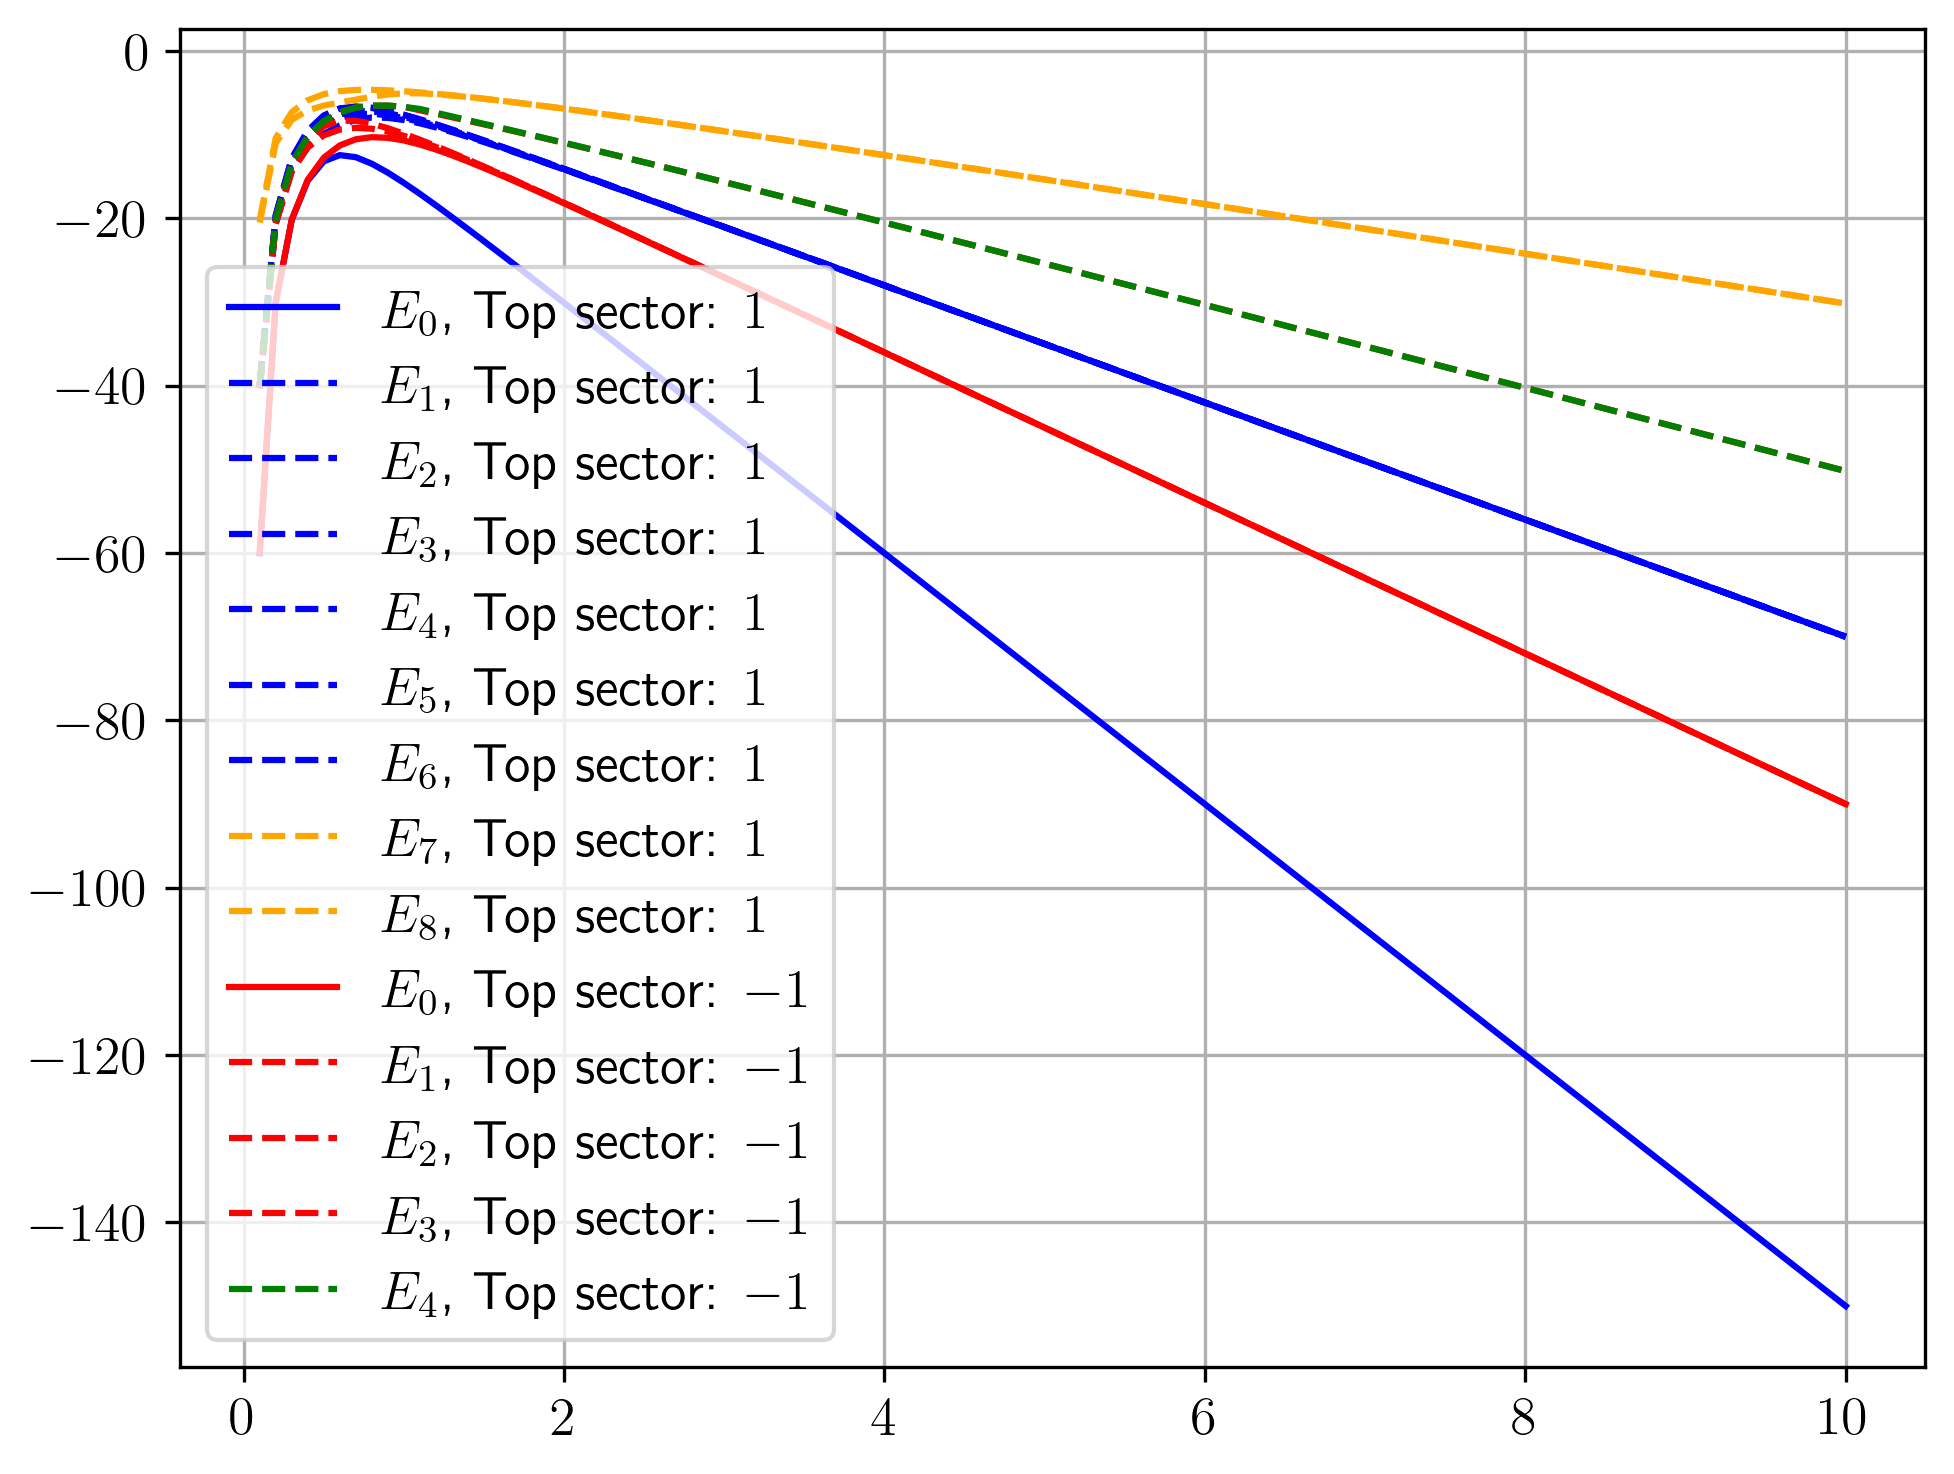

In [107]:
plt.plot(gs, np.asarray(e_dual_p)[:,0], color='blue', label="$E_0$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,1], color='blue', linestyle='--', label="$E_1$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,2], color='blue', linestyle='--', label="$E_2$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,3], color='blue', linestyle='--', label="$E_3$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,4], color='blue', linestyle='--', label="$E_4$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,5], color='blue', linestyle='--', label="$E_5$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,6], color='blue', linestyle='--', label="$E_6$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,7], color='orange', linestyle='--', label="$E_7$, Top sector: $1$")
plt.plot(gs, np.asarray(e_dual_p)[:,8], color='orange', linestyle='--', label="$E_8$, Top sector: $1$")

plt.plot(gs, np.asarray(e_dual_m)[:,0], color='red', label="$E_0$, Top sector: $-1$")
plt.plot(gs, np.asarray(e_dual_m)[:,1], color='red', linestyle='--', label="$E_1$, Top sector: $-1$")
plt.plot(gs, np.asarray(e_dual_m)[:,2], color='red', linestyle='--', label="$E_2$, Top sector: $-1$")
plt.plot(gs, np.asarray(e_dual_m)[:,3], color='red', linestyle='--', label="$E_3$, Top sector: $-1$")
plt.plot(gs, np.asarray(e_dual_m)[:,4], color='green', linestyle='--', label="$E_4$, Top sector: $-1$")
plt.grid(True)
plt.legend()

In [101]:
np.asarray(e_dual_p)[-1,0] - np.asarray(e_dual_m)[-1,0]

-59.99924991877221

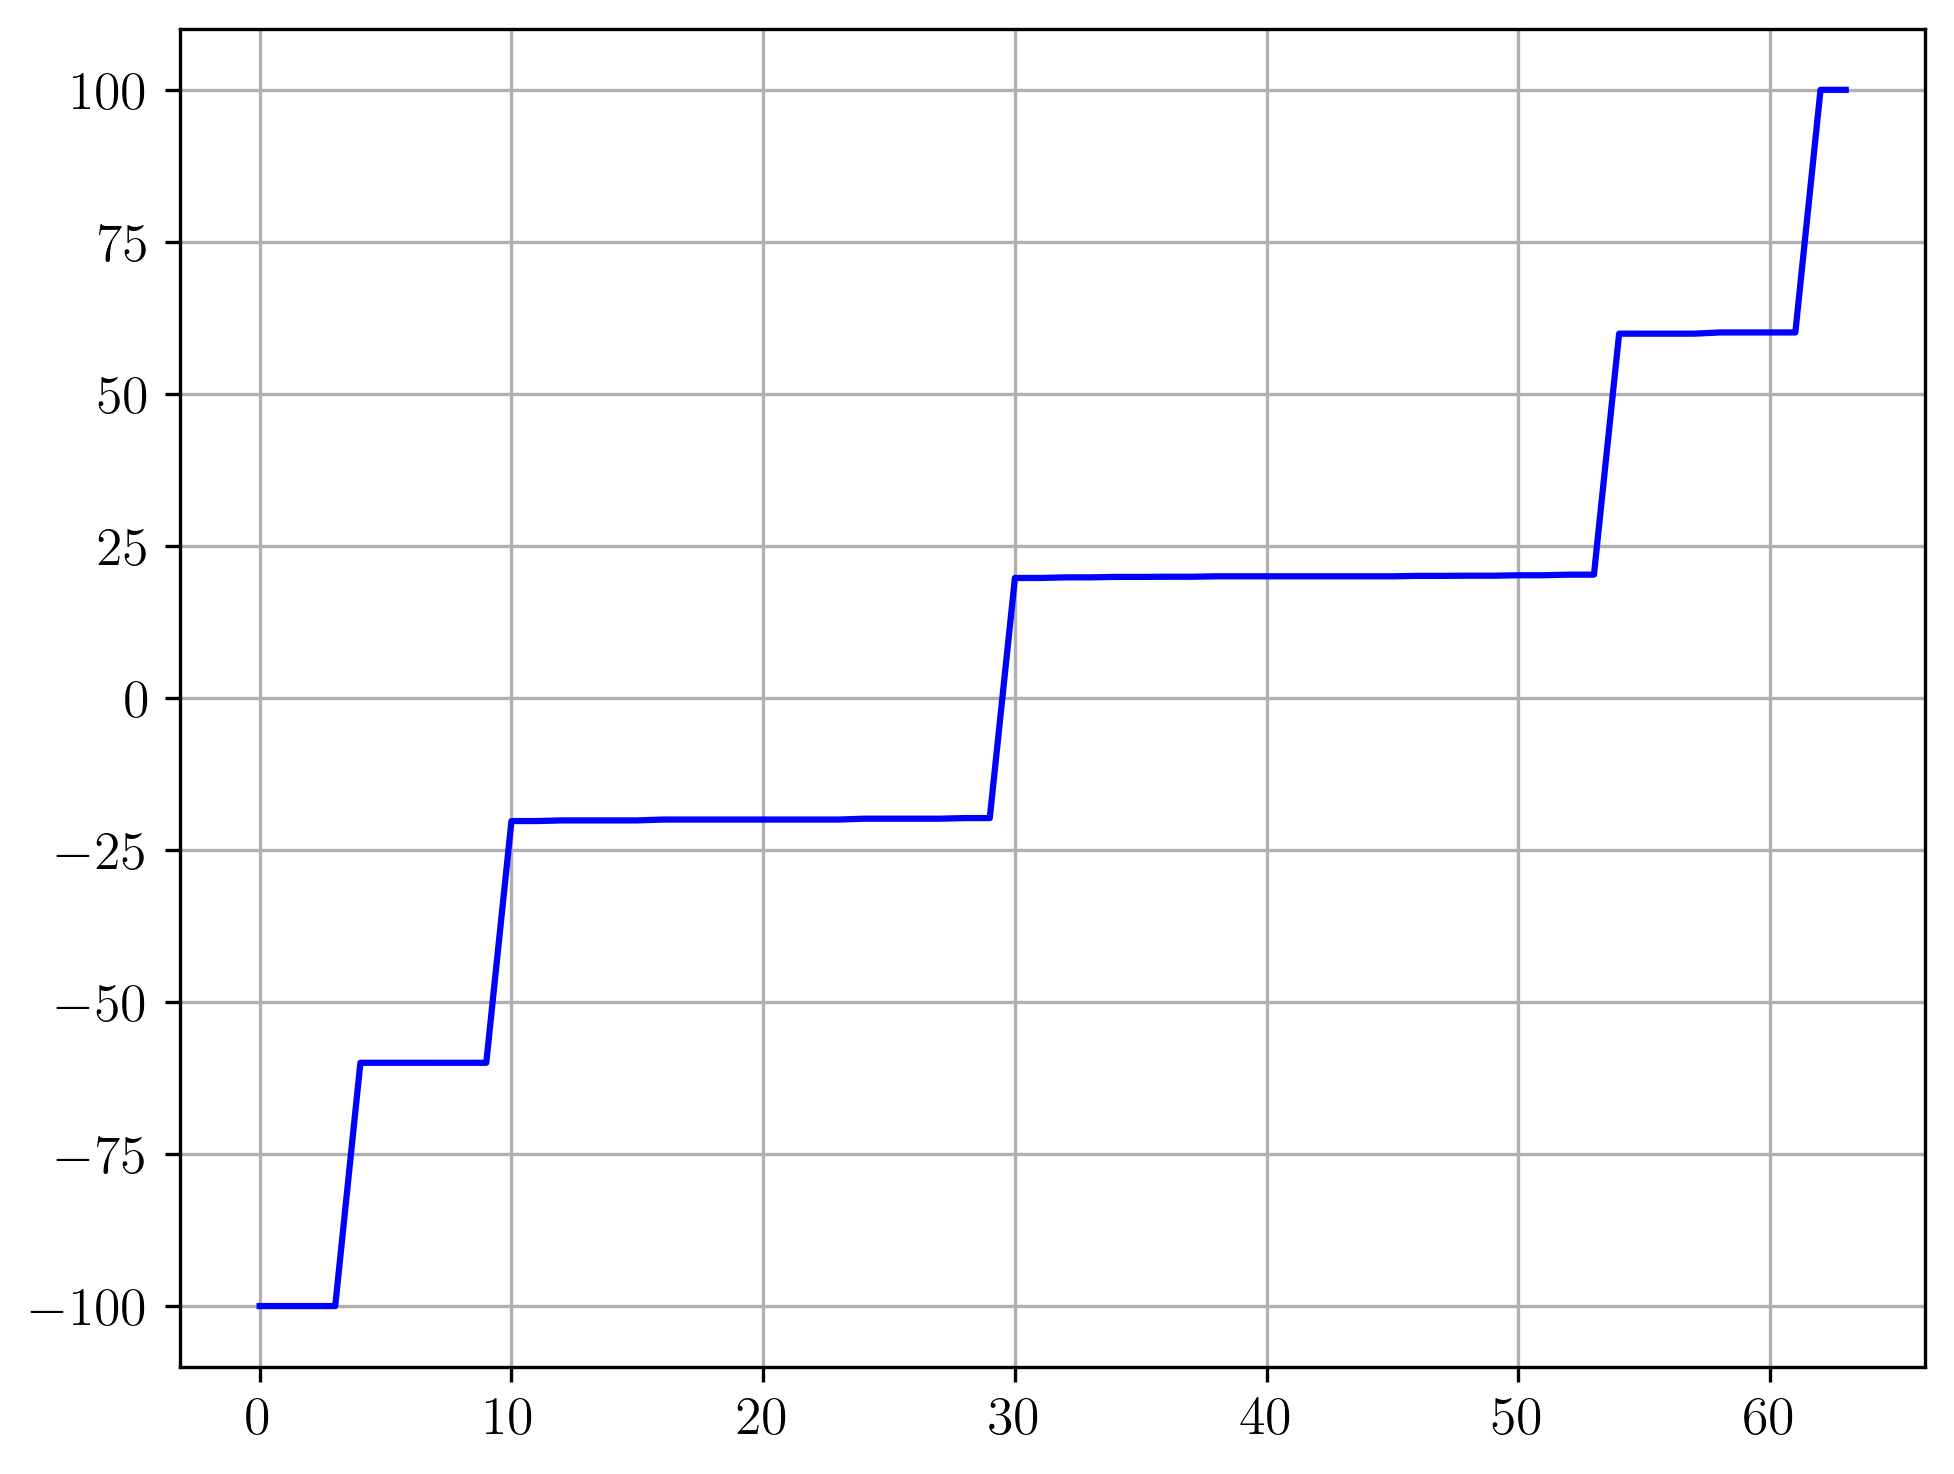

In [125]:
plt.plot(np.asarray(e_dual_m)[-1,:], color='blue')
plt.grid(True)

In [128]:
np.asarray(e_dual_m)[-1,:]

array([-100.00199996, -100.00139036, -100.00074999, -100.00035961,
        -60.000875  ,  -60.000625  ,  -60.0005    ,  -59.99987501,
        -59.99962503,  -59.99950005,  -20.24543756,  -20.24543691,
        -20.14248472,  -20.14198165,  -20.14157766,  -20.14157721,
        -20.00134926,  -20.00117321,  -20.00063924,  -20.0004632 ,
        -20.00018751,  -20.00018751,  -20.00008334,  -20.00008333,
        -19.85964018,  -19.8591433 ,  -19.85873529,  -19.85873486,
        -19.75554227,  -19.75554165,   19.72710299,   19.72745603,
         19.82646263,   19.82746212,   19.89970664,   19.90037674,
         19.92676016,   19.92728165,   20.        ,   20.00014047,
         20.00035643,   20.00037499,   20.00037502,   20.00038934,
         20.00076182,   20.00093521,   20.07317923,   20.07369036,
         20.0997101 ,   20.10037325,   20.17287074,   20.1738712 ,
         20.27350824,   20.27385453,   59.90056505,   59.90056507,
         59.90106098,   59.90106099,   60.10055994,   60.10055

# Energy Spectrum Study

## $2 \times 3$

### Dual Hamiltonian

In [98]:
sparse = True
sparse = False
l, L = 3, 3
dof = l*L
h_i, h_f, npoints = 0.1, 10.0, 100
bc = "pbc"
gs = np.linspace(h_i, h_f, npoints)
e_dual_p = []
e_dual_m = []
R = 0
cx = get_cx(L, R)
cy = get_cy(l, bc, R=R)
cx = []
cy = []
for g in gs:
    print(f"Computing g: {g}")
    H_dual = dual_ham_topo(l,L,g,cx,cy, topol=1)
    e,v = diagonalization(H_dual, sparse=sparse, k=6, maxiter=None)
    e_dual_p.append(e)
    H_dual = dual_ham_topo(l,L,g,cx,cy, topol=-1)
    e,v = diagonalization(H_dual, sparse=sparse, k=6, maxiter=None)
    e_dual_m.append(e)

Computing g: 0.1
Computing g: 0.2
Computing g: 0.30000000000000004
Computing g: 0.4
Computing g: 0.5
Computing g: 0.6
Computing g: 0.7000000000000001
Computing g: 0.8
Computing g: 0.9
Computing g: 1.0
Computing g: 1.1
Computing g: 1.2000000000000002
Computing g: 1.3000000000000003
Computing g: 1.4000000000000001
Computing g: 1.5000000000000002
Computing g: 1.6
Computing g: 1.7000000000000002
Computing g: 1.8000000000000003
Computing g: 1.9000000000000001
Computing g: 2.0
Computing g: 2.1
Computing g: 2.2
Computing g: 2.3000000000000003
Computing g: 2.4000000000000004
Computing g: 2.5000000000000004
Computing g: 2.6
Computing g: 2.7
Computing g: 2.8000000000000003
Computing g: 2.9000000000000004
Computing g: 3.0000000000000004
Computing g: 3.1
Computing g: 3.2
Computing g: 3.3000000000000003
Computing g: 3.4000000000000004
Computing g: 3.5000000000000004
Computing g: 3.6
Computing g: 3.7
Computing g: 3.8000000000000003
Computing g: 3.9000000000000004
Computing g: 4.0
Computing g: 4.1
Co

### Degeneracies

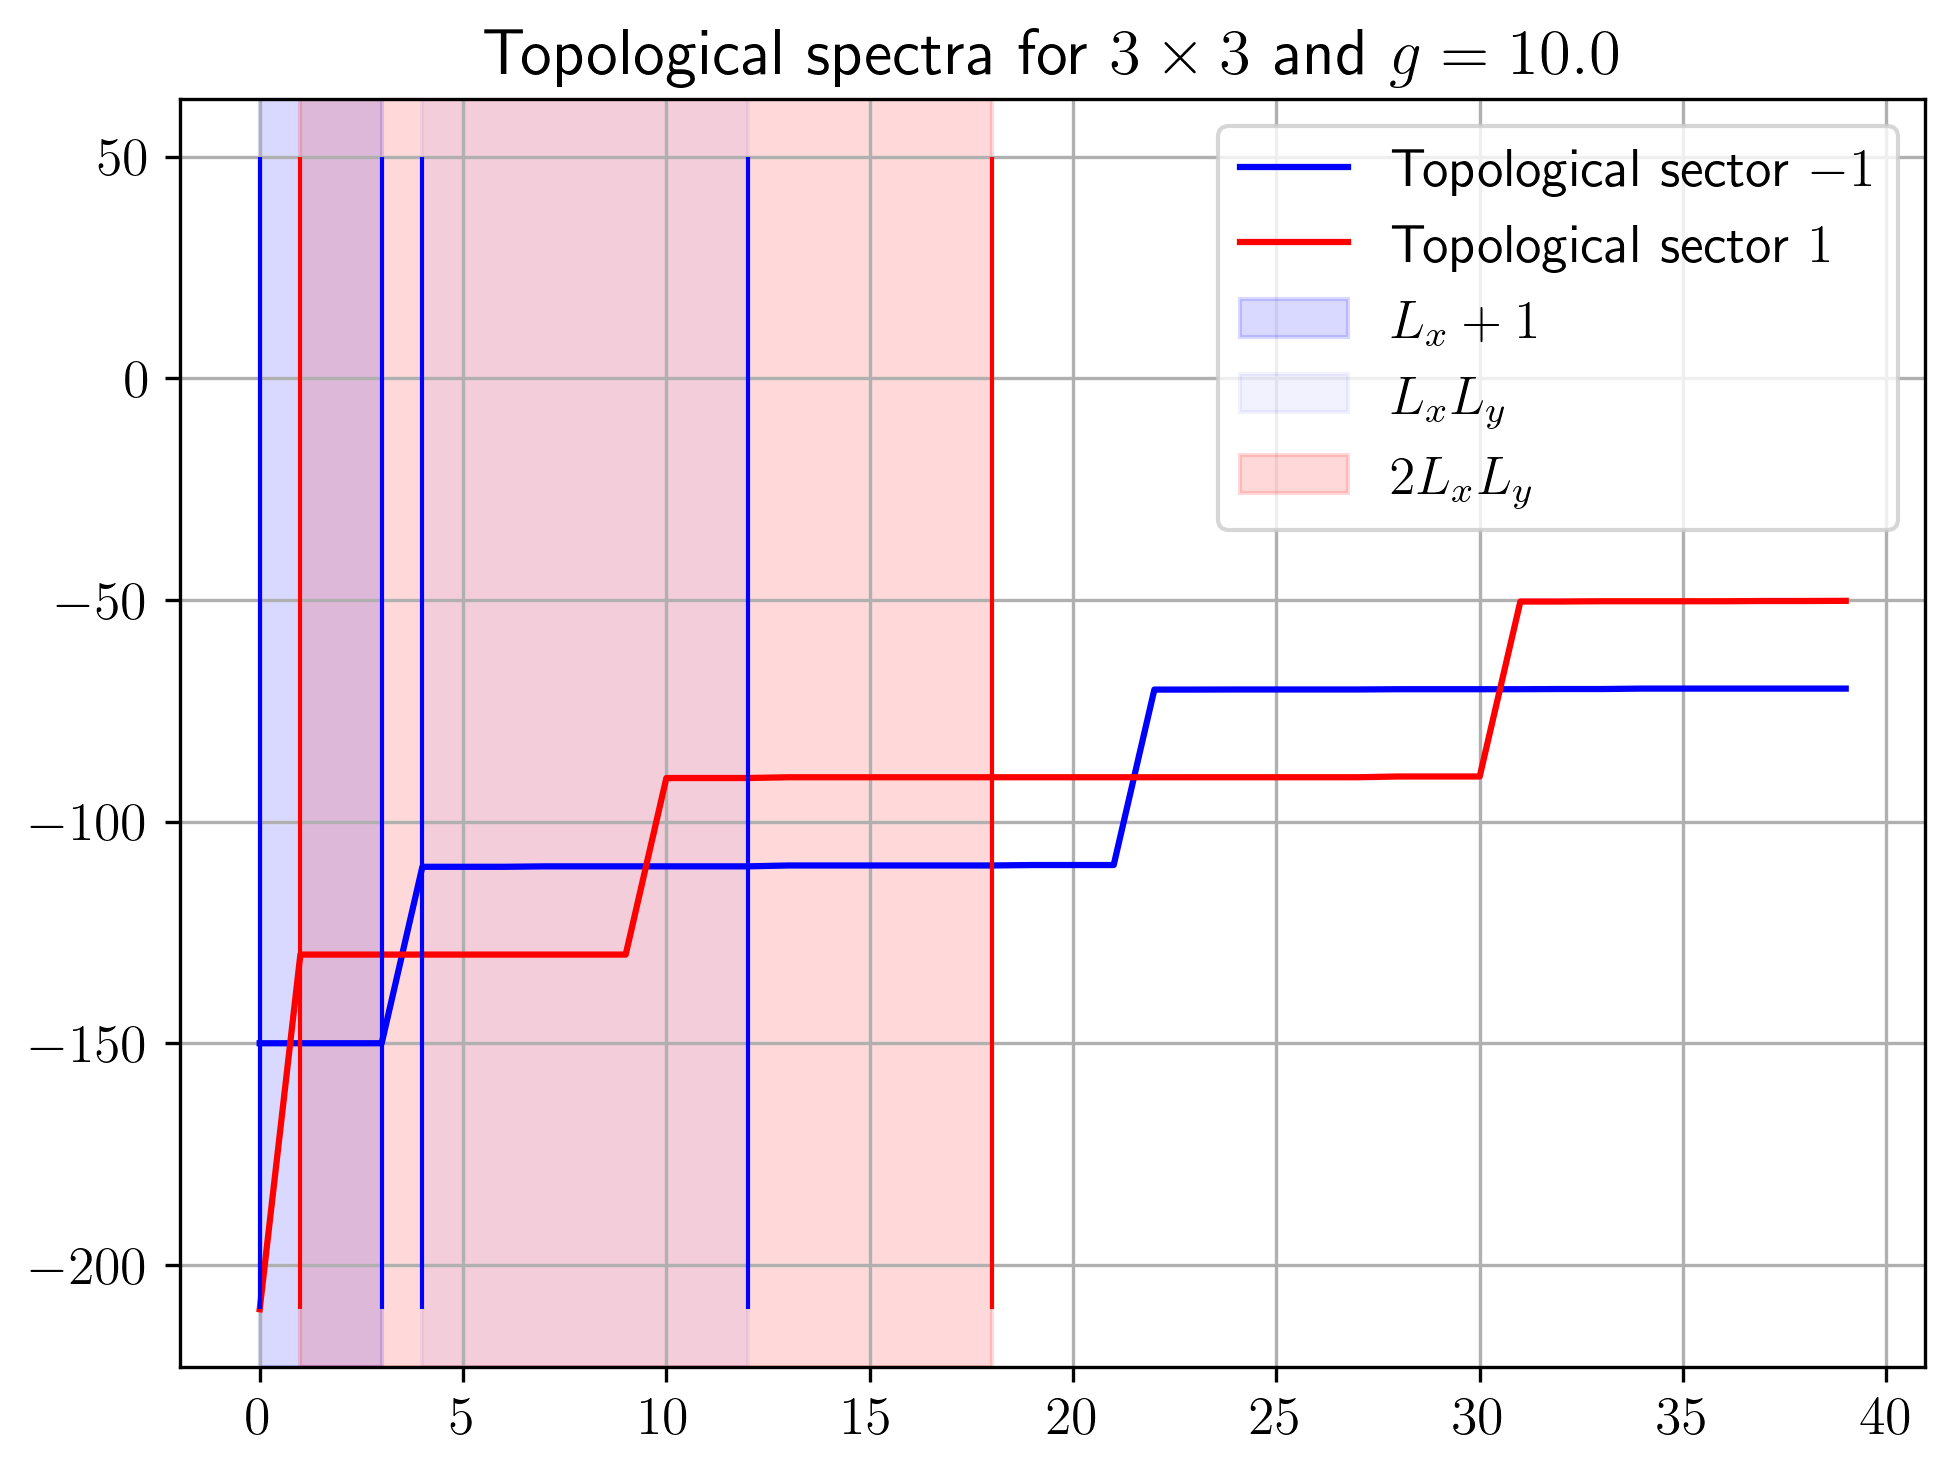

In [99]:
plt.title(f"Topological spectra for ${L}\\times{l}$ and $g={h_f}$")
dof = 2*L*l + l
plt.plot(np.asarray(e_dual_m)[-1,:40], color='blue', label="Topological sector $-1$")
plt.plot(np.asarray(e_dual_p)[-1,:40], color='red', label="Topological sector $1$")

plt.vlines(x=[0, L], ymin=[-dof*h_f,-dof*h_f], ymax=[50,50], colors=["blue", "blue"], linewidth=[1,1])
plt.axvspan(0, L, color='blue', alpha=0.15, zorder=0, label="$L_x+1$")

plt.vlines(x=[L+1, L*l+(L+1)-1], ymin=[-dof*h_f,-dof*h_f], ymax=[50,50], colors=["blue", "blue"], linewidth=[1,1])
plt.axvspan(L+1, L*l+(L+1)-1, color='blue', alpha=0.05, zorder=0, label="$L_x L_y$")

plt.vlines(x=[1, 2*L*l], ymin=[-dof*h_f,-dof*h_f], ymax=[50,50], colors=["red", "red"], linewidth=[1,1])
plt.axvspan(1, 2*L*l, color='red', alpha=0.15, zorder=0, label="$2 L_x L_y$")
plt.grid(True)
plt.legend()

* For ancilla qubit $-1$ we have a first degeneracy in the confined phase due to different, isoenergetic configurations of the closed loop along the cylinder. As in, $L_x + 1$.
Then, the first excited state is due to displacement of the closed loop by one plaquette. The latter costs only two electric links with respect to the ground state of this sector. All the configurations that preserve gauge invariance are $L_x Ly$.  
Excitations are $2 n_l g$ with $n_l = 2,4,6,\dots$

* For ancilla qubit $1$ we have a unique ground state followed by a first degeneracy in the confined phase due to different, isoenergetic configurations of plaquette excitations. As in, $L_x L_y$, one for each plaquette.
Excitations are $2 n_l g$ with $n_l = 4,6,8,\dots$

### MPS first excited

In [111]:
from qs_mps.applications.Z2.ground_state_multiprocessing import ground_state_Z2_param
import datetime as dt

l, L = 4, 4
d = 2**l
cx = np.nan
cy = np.nan
print(cx, cy)
chi = 64
type_shape = "trapezoidal"
model = "Z2_dual"
bc = "pbc"
where = L//2
bond = True
path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
precision = 3
save = False
number_sweeps = 8
conv_tol = 1e-15
training = False
init_tensor = []
sector = "vacuum_sector"
# sector = "2_particle(s)_sector"
args_mps = {
            "L": L,
            "d": d,
            "chi": chi,
            "type_shape": type_shape,
            "model": model,
            "trunc_tol": False,
            "trunc_chi": True,
            "where": where,
            "bond": bond,
            "path": path_tensor,
            "save": save,
            "precision": 3,
            "sector": sector,
            "charges_x": cx,
            "charges_y": cy,
            "n_sweeps": 8,
            "conv_tol": 1e-15,
            "training": training,
            "guess": init_tensor,
            "bc": bc,
            "cc": "h",
            "excited": True
        }

energies, entropies, schmidt_vals, times = [], [], [], []
for p in gs:
    print(f"\n*** Starting param: {p:.5f} in {dt.datetime.now()} ***\n")
    params = [args_mps, p]
    energy, entropy, schmidt_val, t_dmrg = ground_state_Z2_param(params)
    energies.append(energy)
    entropies.append(entropy)
    schmidt_vals.append(schmidt_val)
    times.append(t_dmrg)

nan nan

*** Starting param: 0.10000 in 2025-07-16 13:17:04.206510 ***

Metadata: {'L': 4, 'bc': 'pbc', 'chi': 64, 'cx': nan, 'cy': nan, 'h': 0.1, 'l': 4, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
Running with random state
Sweep n: 0

Sweep n: 1

time of the whole search for h=0.100, chi=64 is: 0:00:02.814695 in date 2025-07-16 13:17:07.059369

*** Starting param: 0.20000 in 2025-07-16 13:17:07.059533 ***

Metadata: {'L': 4, 'bc': 'pbc', 'chi': 64, 'cx': nan, 'cy': nan, 'h': 0.2, 'l': 4, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
Running with random state
Sweep n: 0

Sweep n: 1

time of the whole search for h=0.200, chi=64 is: 0:00:02.110717 in date 2025-07-16 13:17:09.203654

*** Starting param: 0.30000 in 2025-07-16 13:17:09.203918 ***

Metadata: {'L': 4, 'bc': 'pbc', 'chi': 64, 'cx': nan, 'cy': nan, 'h': 0.30000000000000004, 'l': 4, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}
Running with random state
Sweep n: 0

Sweep n: 1

time of the whole search for h=0.300, chi=64 i

### Comparison

In [104]:
try:
    e0_mps = np.load(f"{path_tensor}/results/energy_data/energy_{model}_direct_lattice_{l}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
except:
    e0_mps = np.load(f"{path_tensor}/results/energy_data/energy_{model}_direct_lattice_{l}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")

Text(0.5, 0, '$g$')

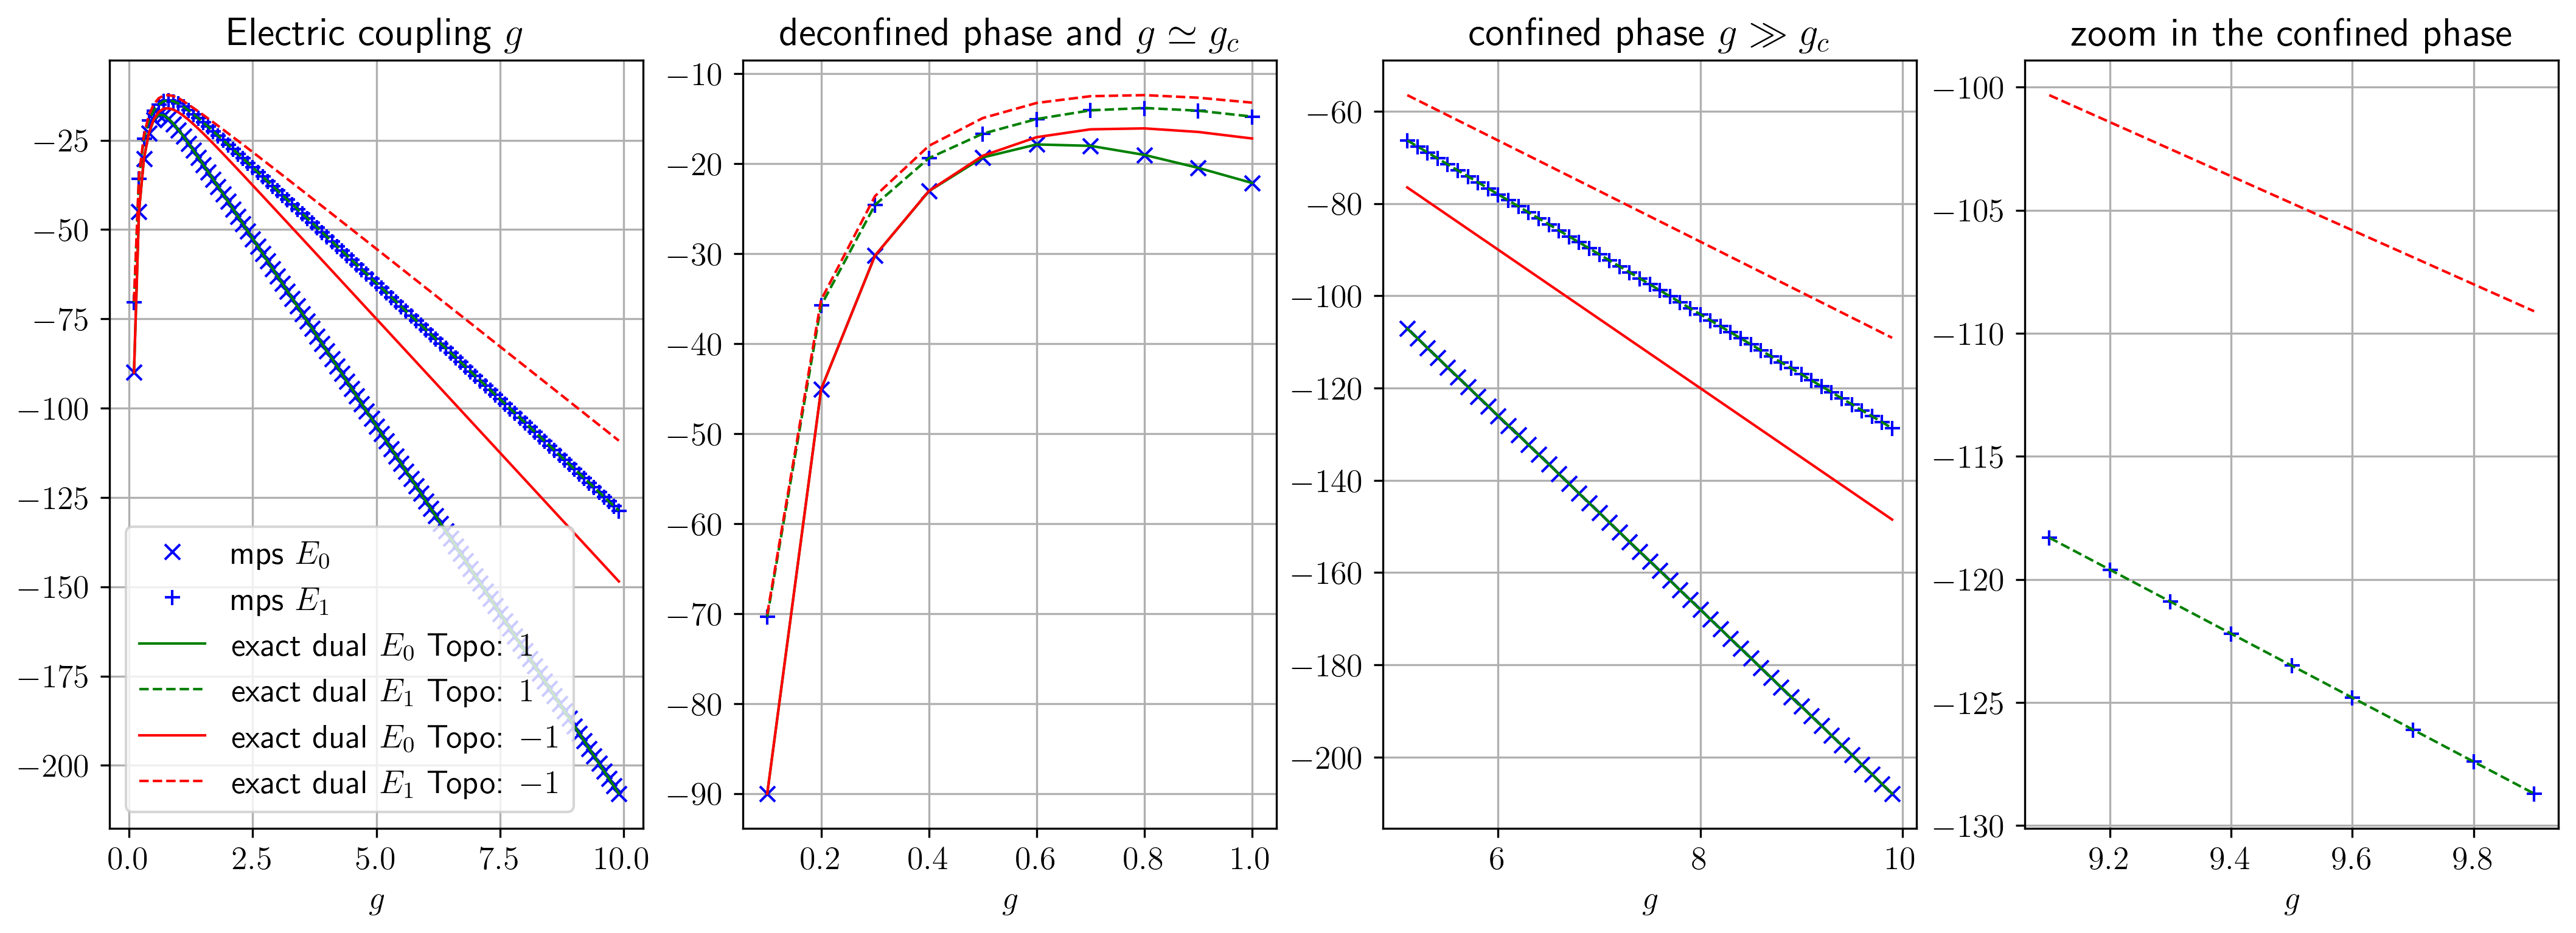

In [105]:
idx1 = 0
idx2 = -1
fig, axs =plt.subplots(1,4,figsize=(14,5))
axs[0].plot(gs[idx1:idx2], e0_mps[idx1:idx2], 'x', color='blue', label="mps $E_0$")
axs[0].plot(gs[idx1:idx2], energies[idx1:idx2], '+', color='blue', label="mps $E_1$")
axs[0].plot(gs[idx1:idx2], np.asarray(e_dual_p)[idx1:idx2,0], label="exact dual $E_0$ Topo: $1$", linewidth=1, color='green')
axs[0].plot(gs[idx1:idx2], np.asarray(e_dual_p)[idx1:idx2,1], label="exact dual $E_1$ Topo: $1$", linewidth=1, linestyle="--", color='green')
axs[0].plot(gs[idx1:idx2], np.asarray(e_dual_m)[idx1:idx2,0], label="exact dual $E_0$ Topo: $-1$", linewidth=1, color='red')
axs[0].plot(gs[idx1:idx2], np.asarray(e_dual_m)[idx1:idx2,L+1], label="exact dual $E_1$ Topo: $-1$", linewidth=1, linestyle="--", color='red')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title("Electric coupling $g$")
axs[0].set_xlabel("$g$")

idx1 = 0
idx2 = 10
axs[1].plot(gs[idx1:idx2], energies[idx1:idx2], '+', color='blue', label="mps $E_1$")
axs[1].plot(gs[idx1:idx2], e0_mps[idx1:idx2], 'x', color='blue', label="mps $E_0$")
axs[1].plot(gs[idx1:idx2], np.asarray(e_dual_p)[idx1:idx2,0], label="exact dual $E_0$ Topo: $1$", linewidth=1, color='green')
axs[1].plot(gs[idx1:idx2], np.asarray(e_dual_p)[idx1:idx2,1], label="exact dual $E_1$ Topo: $1$", linewidth=1, linestyle="--", color='green')
axs[1].plot(gs[idx1:idx2], np.asarray(e_dual_m)[idx1:idx2,0], label="exact dual $E_0$ Topo: $-1$", linewidth=1, color='red')
axs[1].plot(gs[idx1:idx2], np.asarray(e_dual_m)[idx1:idx2,L+1], label="exact dual $E_1$ Topo: $-1$", linewidth=1, linestyle="--", color='red')
# axs[1].legend()
axs[1].grid(True)
axs[1].set_title("deconfined phase and $g \\simeq g_c$")
axs[1].set_xlabel("$g$")

idx1 = 50
idx2 = -1
axs[2].plot(gs[idx1:idx2], energies[idx1:idx2], '+', color='blue', label="mps $E_1$")
axs[2].plot(gs[idx1:idx2], e0_mps[idx1:idx2], 'x', color='blue', label="mps $E_0$")
axs[2].plot(gs[idx1:idx2], np.asarray(e_dual_p)[idx1:idx2,0], label="exact dual $E_0$ Topo: $1$", linewidth=1, color='green')
axs[2].plot(gs[idx1:idx2], np.asarray(e_dual_p)[idx1:idx2,1], label="exact dual $E_1$ Topo: $1$", linewidth=1, linestyle="--", color='green')
axs[2].plot(gs[idx1:idx2], np.asarray(e_dual_m)[idx1:idx2,0], label="exact dual $E_0$ Topo: $-1$", linewidth=1, color='red')
axs[2].plot(gs[idx1:idx2], np.asarray(e_dual_m)[idx1:idx2,L+1], label="exact dual $E_1$ Topo: $-1$", linewidth=1, linestyle="--", color='red')
# axs[2].legend()
axs[2].grid(True)
axs[2].set_title(" confined phase $g \\gg g_c$")
axs[2].set_xlabel("$g$")

idx1 = 90
idx2 = -1
axs[3].plot(gs[idx1:idx2], energies[idx1:idx2], '+', color='blue', label="mps $E_1$")
axs[3].plot(gs[idx1:idx2], np.asarray(e_dual_p)[idx1:idx2,1], label="exact dual $E_1$ Topo: $1$", linewidth=1, linestyle="--", color='green')
axs[3].plot(gs[idx1:idx2], np.asarray(e_dual_m)[idx1:idx2,L+1], label="exact dual $E_1$ Topo: $-1$", linewidth=1, linestyle="--", color='red')
# axs[3].legend()
axs[3].grid(True)
axs[3].set_title("zoom in the confined phase")
axs[3].set_xlabel("$g$")

## $3 \times 2$

### Dual Hamiltonian

In [60]:
sparse = True
sparse = False
l, L = 4, 2
dof = l*L
h_i, h_f, npoints = 0.1, 10.0, 100
gs = np.linspace(h_i, h_f, npoints)
e_dual_p = []
e_dual_m = []
R = 0
cx = get_cx(L, R)
cy = get_cy(l, bc, R=R)
cx = []
cy = []
for g in gs:
    print(f"Computing g: {g}")
    H_dual = dual_ham_topo(l,L,g,cx,cy, topol=1)
    e,v = diagonalization(H_dual, sparse=sparse, k=6, maxiter=None)
    e_dual_p.append(e)
    H_dual = dual_ham_topo(l,L,g,cx,cy, topol=-1)
    e,v = diagonalization(H_dual, sparse=sparse, k=6, maxiter=None)
    e_dual_m.append(e)

Computing g: 0.1
Computing g: 0.2
Computing g: 0.30000000000000004
Computing g: 0.4
Computing g: 0.5
Computing g: 0.6
Computing g: 0.7000000000000001
Computing g: 0.8
Computing g: 0.9
Computing g: 1.0
Computing g: 1.1
Computing g: 1.2000000000000002
Computing g: 1.3000000000000003
Computing g: 1.4000000000000001
Computing g: 1.5000000000000002
Computing g: 1.6
Computing g: 1.7000000000000002
Computing g: 1.8000000000000003
Computing g: 1.9000000000000001
Computing g: 2.0
Computing g: 2.1
Computing g: 2.2
Computing g: 2.3000000000000003
Computing g: 2.4000000000000004
Computing g: 2.5000000000000004
Computing g: 2.6
Computing g: 2.7
Computing g: 2.8000000000000003
Computing g: 2.9000000000000004
Computing g: 3.0000000000000004
Computing g: 3.1
Computing g: 3.2
Computing g: 3.3000000000000003
Computing g: 3.4000000000000004
Computing g: 3.5000000000000004
Computing g: 3.6
Computing g: 3.7
Computing g: 3.8000000000000003
Computing g: 3.9000000000000004
Computing g: 4.0
Computing g: 4.1
Co

### Degeneracies

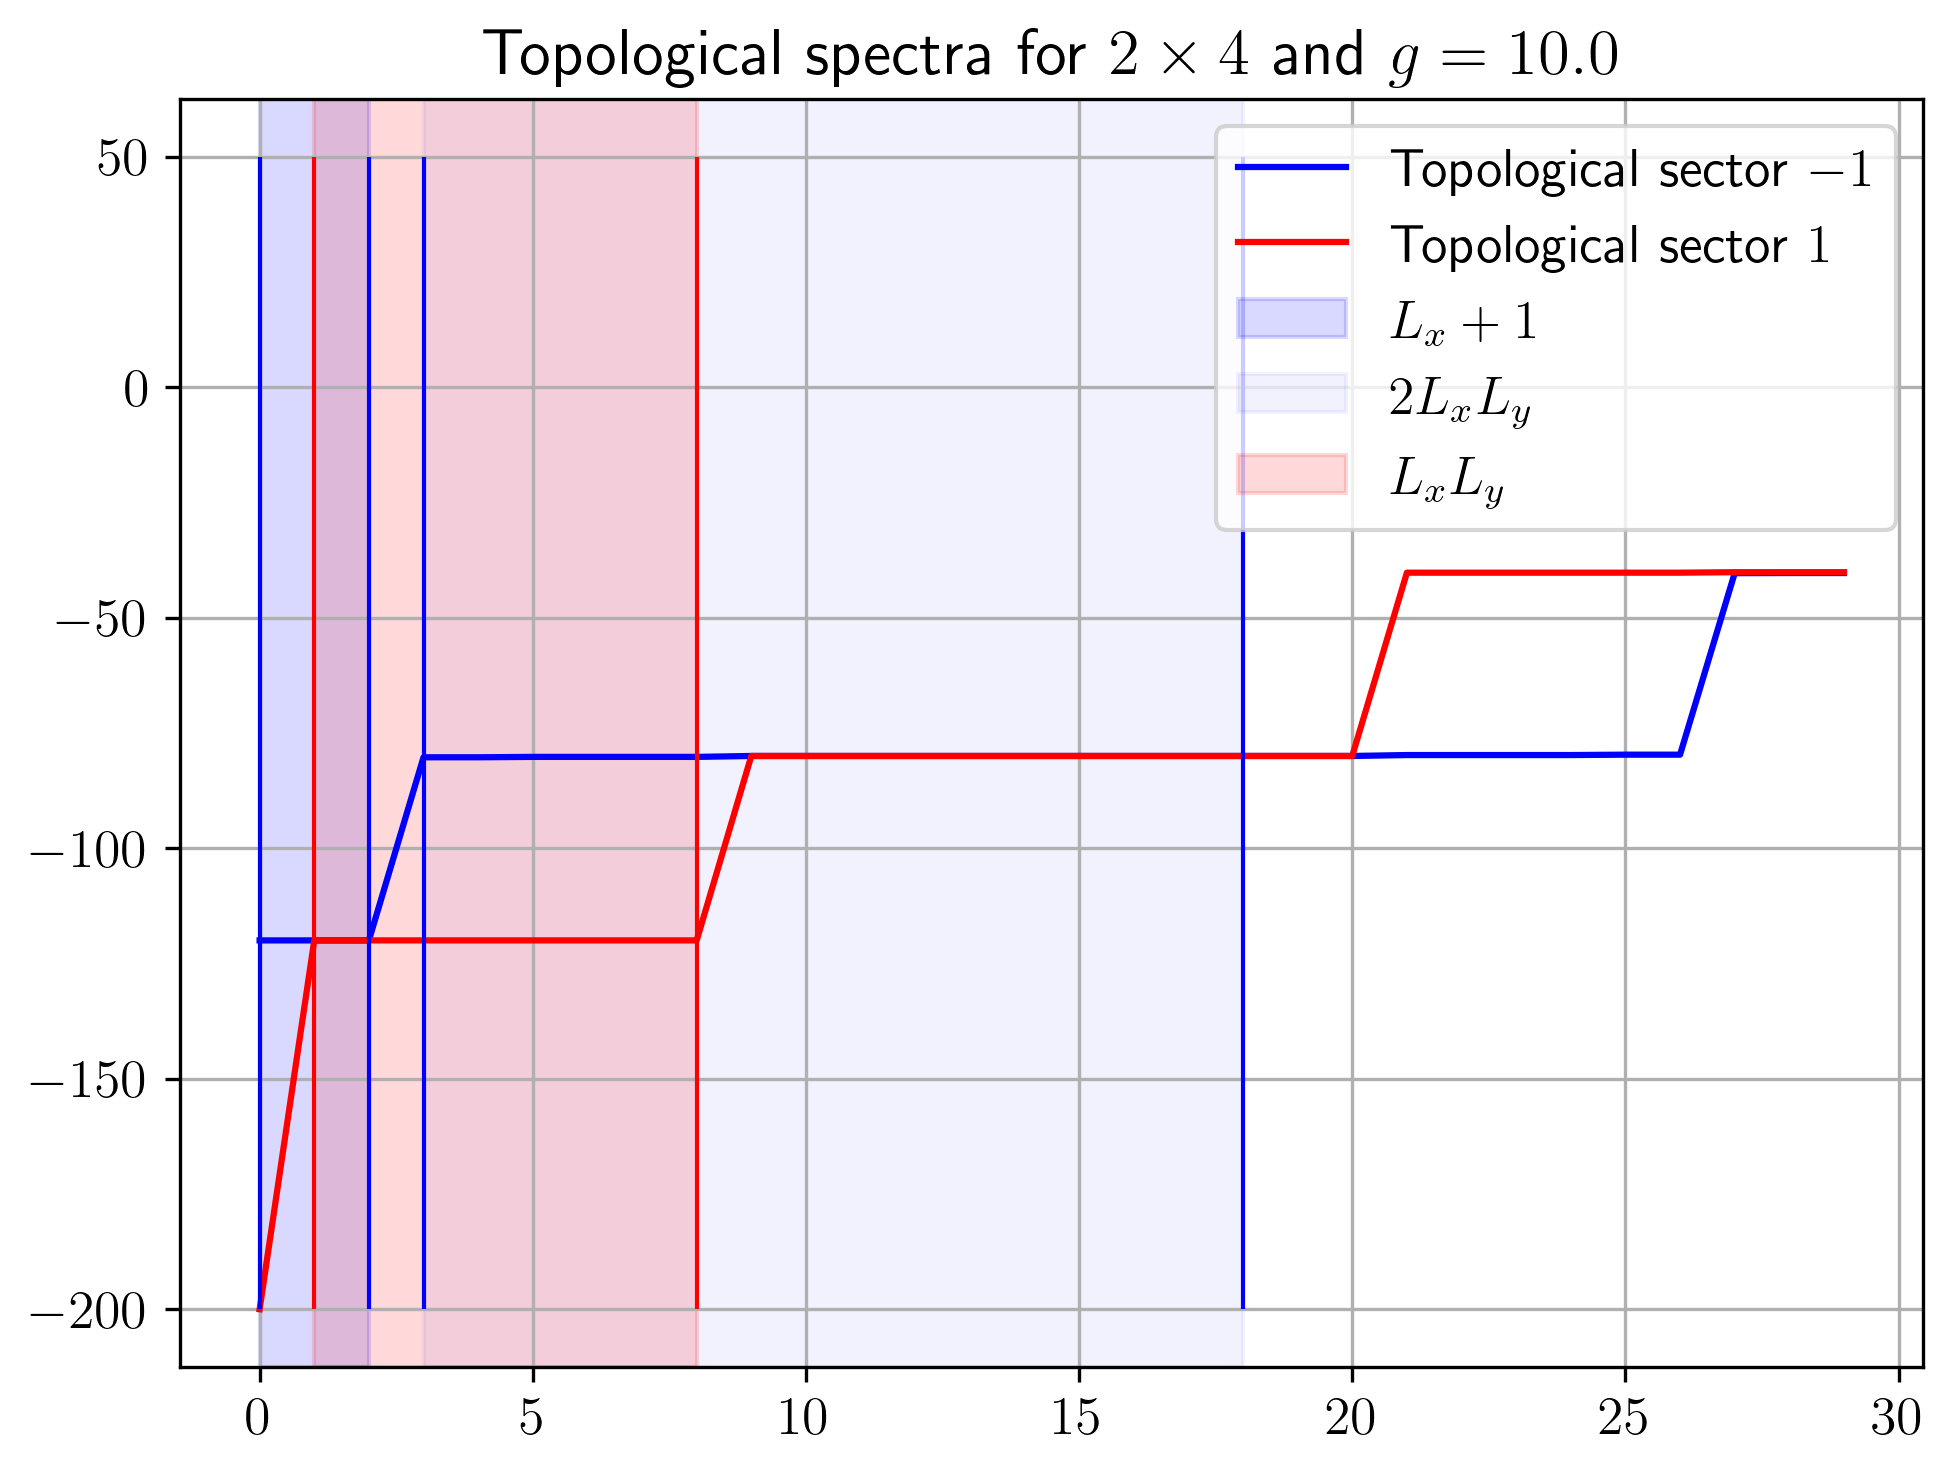

In [62]:
plt.title(f"Topological spectra for ${L}\\times{l}$ and $g={h_f}$")
dof = 2*L*l + l
plt.plot(np.asarray(e_dual_m)[-1,:30], color='blue', label="Topological sector $-1$")
plt.plot(np.asarray(e_dual_p)[-1,:30], color='red', label="Topological sector $1$")
plt.vlines(x=[0, L], ymin=[-dof*h_f,-dof*h_f], ymax=[50,50], colors=["blue", "blue"], linewidth=[1,1])
plt.axvspan(0, L, color='blue', alpha=0.15, zorder=0, label="$L_x+1$")

plt.vlines(x=[L+1, 2*L*l+(L+1)-1], ymin=[-dof*h_f,-dof*h_f], ymax=[50,50], colors=["blue", "blue"], linewidth=[1,1])
plt.axvspan(L+1, 2*L*l+(L+1)-1, color='blue', alpha=0.05, zorder=0, label="$2 L_x L_y$")

plt.vlines(x=[1, L*l], ymin=[-dof*h_f,-dof*h_f], ymax=[50,50], colors=["red", "red"], linewidth=[1,1])
plt.axvspan(1, L*l, color='red', alpha=0.15, zorder=0, label="$L_x L_y$")
plt.grid(True)
plt.legend()

### MPS first excited